# CS675 Introduction to Data Science - Project #3

**Aayushi Verma**

The aim of this project is to perform time series forecasting for New York City's electric consumption for its 5 boroughs. We use the FB Prophet package to perform most of the analysis in this project.

In [211]:
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
import datetime as dt
from prophet.plot import add_changepoints_to_plot
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_cross_validation_metric
from dask.distributed import Client
import itertools

## Step One: Inspecting and Cleaning the Data

This dataset is obtained from: https://data.cityofnewyork.us/Housing-Development/Electric-Consumption-And-Cost-2010-Feb-2022-/jr24-e7cr. It details the monthly consumption and cost data by the 5 boroughs of New York.

In [212]:
raw = pd.read_csv("data.csv")

/var/folders/n9/3mjn__fd1xd66lc1zh9nlj0h0000gp/T/ipykernel_58233/2433355955.py:1: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  raw = pd.read_csv("data.csv")


In [213]:
raw.head()

Development Name Borough Account Name Location Meter AMR   Meter Scope  \
0            ADAMS   BRONX        ADAMS   BLD 05      NONE  BLD 01 to 07   
1            ADAMS   BRONX        ADAMS   BLD 05      NONE  BLD 01 to 07   
2            ADAMS   BRONX        ADAMS   BLD 05      NONE  BLD 01 to 07   
3            ADAMS   BRONX        ADAMS   BLD 05      NONE  BLD 01 to 07   
4            ADAMS   BRONX        ADAMS   BLD 05      NONE  BLD 01 to 07   

   TDS #  EDP  RC Code Funding Source  ... Meter Number Estimated  \
0  118.0  248  B011800        FEDERAL  ...      7223256         N   
1  118.0  248  B011800        FEDERAL  ...      7223256         N   
2  118.0  248  B011800        FEDERAL  ...      7223256         N   
3  118.0  248  B011800        FEDERAL  ...      7223256         N   
4  118.0  248  B011800        FEDERAL  ...      7223256         N   

   Current Charges   Rate Class Bill Analyzed Consumption (KWH)  KWH Charges  \
0         15396.82  GOV/NYC/068           Yes            128800      7387.97   
1         14556.34  GOV/NYC/068           Yes            115200      6607.87   
2         13904.98  GOV/NYC/068           Yes            103200      5919.55   
3         14764.04  GOV/NYC/068           Yes            105600      6057.22   
4         13729.54  GOV/NYC/068           Yes             97600      5598.34   

  Consumption (KW) KW Charges  Other charges  
0            216.0     2808.0        5200.85  
1            224.0     2912.0        5036.47  
2            216.0     2808.0        5177.43  
3            208.0     2704.0        6002.82  
4            216.0     2808.0        5323.20  

[5 rows x 27 columns]

In [214]:
raw['Consumption (KWH)'].describe()

count    4.070310e+05
mean     3.142596e+04
std      4.927138e+04
min      0.000000e+00
25%      0.000000e+00
50%      1.400000e+04
75%      4.640000e+04
max      1.779600e+06
Name: Consumption (KWH), dtype: float64

In [215]:
raw.shape

(407031, 27)

In [216]:
raw.isnull().sum()

Development Name        1086
Borough                    0
Account Name               0
Location               10625
Meter AMR                186
Meter Scope           385539
TDS #                   2343
EDP                        0
RC Code                    0
Funding Source             0
AMP #                   1886
Vendor Name                0
UMIS BILL ID               0
Revenue Month              0
Service Start Date         8
Service End Date           8
# days                     8
Meter Number               0
Estimated                342
Current Charges            0
Rate Class                 0
Bill Analyzed              0
Consumption (KWH)          0
KWH Charges                0
Consumption (KW)           0
KW Charges                 0
Other charges              0
dtype: int64

We see that there are a lot of null values. Dropping these null values might help us also reduce the size of our dataframe for subsequent analysis to help with processing time, as well as allowing for better predictions.

In [217]:
df = raw.dropna()
df.isnull().sum()

Development Name      0
Borough               0
Account Name          0
Location              0
Meter AMR             0
Meter Scope           0
TDS #                 0
EDP                   0
RC Code               0
Funding Source        0
AMP #                 0
Vendor Name           0
UMIS BILL ID          0
Revenue Month         0
Service Start Date    0
Service End Date      0
# days                0
Meter Number          0
Estimated             0
Current Charges       0
Rate Class            0
Bill Analyzed         0
Consumption (KWH)     0
KWH Charges           0
Consumption (KW)      0
KW Charges            0
Other charges         0
dtype: int64

In [218]:
df.shape

(21049, 27)

Indeed, the shape of the dataframe was nearly halved!

Now that we have cleaned the data, the next step is to consider the data columns we will be using. We are interested in forecasting the electricity consumption of NYC's boroughs over time. So we need a column with dates, a column with energy consumption, and a column for the boroughs. Inspecting the ```df.head()``` we looked at earlier, we see that there are a few date-like columns, and 2 different columns that measure electricity consumption. I have detailed my choices as below:
- Date column: I will use ```Service End Date``` as the date column, since it has dates granular to the date level, instead of e.g. months or years. This will allow for better forecasting because of more data points.
- Energy consumption column: I will use ```Consumption (KWH)``` to measure electricity consumption instead of ```Consumption (KW)```, since kW is a measure of the *rate* of energy used, not the consumption.

Therefore, we will now convert the dataframe to allow these columns only, and further clean up the data by changing data types.

In [219]:
df['Service End Date'] = pd.to_datetime(df['Service End Date'])
df = df.rename(columns={'Service End Date':'ds','Consumption (KWH)':'y'})
df['year'] = df['ds'].dt.year
df['month'] = df['ds'].dt.month
df['day'] = df['ds'].dt.day

/var/folders/n9/3mjn__fd1xd66lc1zh9nlj0h0000gp/T/ipykernel_58233/2313118396.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Service End Date'] = pd.to_datetime(df['Service End Date'])


Now we want to visualize this data, just to get a better sense of it.

Text(0, 0.5, 'consumption (KWH)')

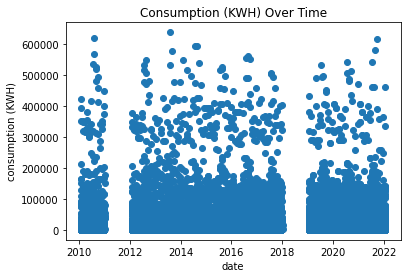

In [221]:
plt.scatter(df['ds'],df['y'])
plt.title("Consumption (KWH) Over Time")
plt.xlabel("date")
plt.ylabel("consumption (KWH)")

We see that there are gaps roughly in the years 2011 and 2018. We will need to be careful of this.

In [301]:
df2 = df.copy()
df2.head()

Development Name Borough Account Name Location Meter AMR   Meter Scope  \
0            ADAMS   BRONX        ADAMS   BLD 05      NONE  BLD 01 to 07   
1            ADAMS   BRONX        ADAMS   BLD 05      NONE  BLD 01 to 07   
2            ADAMS   BRONX        ADAMS   BLD 05      NONE  BLD 01 to 07   
3            ADAMS   BRONX        ADAMS   BLD 05      NONE  BLD 01 to 07   
4            ADAMS   BRONX        ADAMS   BLD 05      NONE  BLD 01 to 07   

   TDS #  EDP  RC Code Funding Source  ... Bill Analyzed       y  KWH Charges  \
0  118.0  248  B011800        FEDERAL  ...           Yes  128800      7387.97   
1  118.0  248  B011800        FEDERAL  ...           Yes  115200      6607.87   
2  118.0  248  B011800        FEDERAL  ...           Yes  103200      5919.55   
3  118.0  248  B011800        FEDERAL  ...           Yes  105600      6057.22   
4  118.0  248  B011800        FEDERAL  ...           Yes   97600      5598.34   

  Consumption (KW) KW Charges Other charges  year month day   cap  
0            216.0     2808.0       5200.85  2010     1  26  9000  
1            224.0     2912.0       5036.47  2010     2  25  9000  
2            216.0     2808.0       5177.43  2010     3  26  9000  
3            208.0     2704.0       6002.82  2010     4  26  9000  
4            216.0     2808.0       5323.20  2010     5  24  9000  

[5 rows x 31 columns]

Now we will average out the data by year, month, and date. We do this by grouping by the relevant variables and applying the mean to all applicable data rows.

In [302]:
df2['avg_by_year'] = df2.groupby('year')['y'].transform('mean')
df2['avg_by_month'] = df2.groupby(['year','month'])['y'].transform('mean')
df2['avg_by_day'] = df2.groupby(['year','month','day'])['y'].transform('mean')
df2 = df2[['ds','avg_by_year','avg_by_month','avg_by_day','Borough']]

In [225]:
df2.describe()

avg_by_year   avg_by_month     avg_by_day
count   21049.000000   21049.000000   21049.000000
mean    22954.689962   22954.689962   22954.689962
std      1220.517007    4195.773467   27475.572963
min      7746.666667    7746.666667       0.000000
25%     22359.887574   20003.813253   14101.791946
50%     22925.097200   21490.343195   16487.845912
75%     23924.659259   24505.473054   20936.621302
max    150980.000000  150980.000000  542000.000000

In [226]:
df2.tail()

ds   avg_by_year  avg_by_month    avg_by_day   Borough
406348 2021-09-22  22024.948729  26349.353933  20094.051948  BROOKLYN
406349 2021-10-22  22024.948729  19695.174419  15564.709677  BROOKLYN
406350 2021-11-22  22024.948729  18125.424419  12786.664430  BROOKLYN
406351 2021-12-23  22024.948729  20785.573099  13981.832215  BROOKLYN
406352 2022-01-25  22359.887574  22359.887574  15447.195946  BROOKLYN

We will now separate out the dataframe into three smaller subsets of data for each of the three variables - year, month and date.

In [227]:
df_by_year = df2.rename(columns={'avg_by_year':'y'})[['ds','y','Borough']].dropna().reset_index(drop=True)
df_by_month = df2.rename(columns={'avg_by_month':'y'})[['ds','y','Borough']].dropna().reset_index(drop=True)
df_by_day = df2.rename(columns={'avg_by_day':'y'})[['ds','y','Borough']].dropna().reset_index(drop=True)

In [228]:
df_by_year.tail()

ds             y   Borough
21044 2021-09-22  22024.948729  BROOKLYN
21045 2021-10-22  22024.948729  BROOKLYN
21046 2021-11-22  22024.948729  BROOKLYN
21047 2021-12-23  22024.948729  BROOKLYN
21048 2022-01-25  22359.887574  BROOKLYN

In [229]:
df_by_year['y'].describe()

count     21049.000000
mean      22954.689962
std        1220.517007
min        7746.666667
25%       22359.887574
50%       22925.097200
75%       23924.659259
max      150980.000000
Name: y, dtype: float64

In [230]:
df_by_month['y'].describe()

count     21049.000000
mean      22954.689962
std        4195.773467
min        7746.666667
25%       20003.813253
50%       21490.343195
75%       24505.473054
max      150980.000000
Name: y, dtype: float64

In [231]:
df_by_day['y'].describe()

count     21049.000000
mean      22954.689962
std       27475.572963
min           0.000000
25%       14101.791946
50%       16487.845912
75%       20936.621302
max      542000.000000
Name: y, dtype: float64

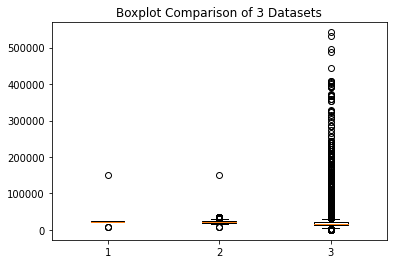

In [235]:
data = [df_by_year['y'], df_by_month['y'], df_by_day['y']]
fig, ax = plt.subplots()
ax.set_title('Boxplot Comparison of 3 Datasets')
ax.boxplot(data)
plt.show()

All these susbets, especially the df_by_day dataset seem to have a lot of outliers. We will need to be careful of this, and will attempt to remove some of the most extreme outliers.

In [238]:
def plot_data_check(df):
    plt.scatter(df['ds'],df['y'])
    plt.axhline(df['y'].mean(),color="red")

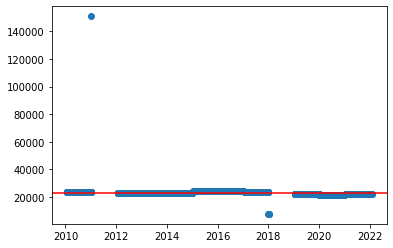

In [239]:
plot_data_check(df_by_year)

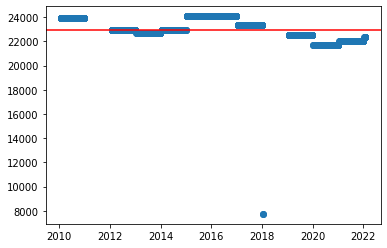

In [240]:
df_by_year = df_by_year.drop(index=[df_by_year[df_by_year['y']==df_by_year['y'].min()].index[0]], axis=0)
df_by_year = df_by_year.drop(index=[df_by_year[df_by_year['y']==df_by_year['y'].max()].index[0]], axis=0)
plot_data_check(df_by_year)

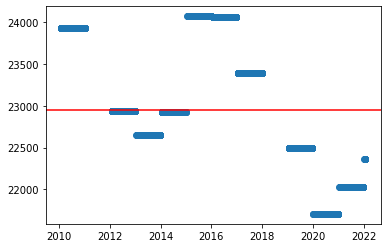

In [241]:
df_by_year = df_by_year.drop(index=[df_by_year[df_by_year['y']==df_by_year['y'].min()].index[0]], axis=0)
df_by_year = df_by_year.drop(index=[df_by_year[df_by_year['y']==df_by_year['y'].min()].index[0]], axis=0)
plot_data_check(df_by_year)

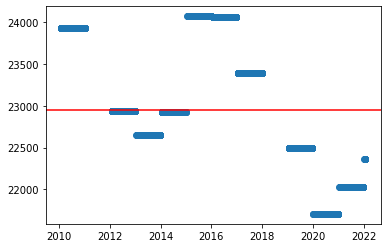

In [242]:
plot_data_check(df_by_year)

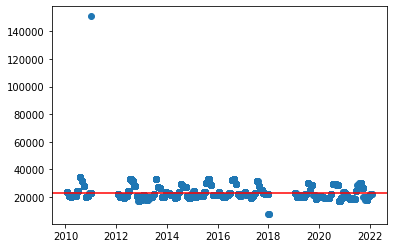

In [243]:
plot_data_check(df_by_month)

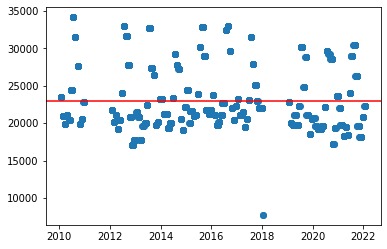

In [244]:
df_by_month = df_by_month.drop(index=[df_by_month[df_by_month['y']==df_by_month['y'].max()].index[0]], axis=0)
df_by_month = df_by_month.drop(index=[df_by_month[df_by_month['y']==df_by_month['y'].min()].index[0]], axis=0)
plot_data_check(df_by_month)

## Step Two: Fitting Model

In [245]:
def future_preds(df,period):
    m = Prophet()
    m.fit(df)
    future = m.make_future_dataframe(period) #period is in units of days
    forecast = m.predict(future)
    fig1 = m.plot(forecast);
    fig2 = m.plot_components(forecast);
    return (m, future, forecast, fig1, fig2)

### By Year

18:01:13 - cmdstanpy - INFO - Chain [1] start processing
18:02:04 - cmdstanpy - INFO - Chain [1] done processing


ds          yhat    yhat_lower    yhat_upper
829 2023-01-24  22538.235695  20755.881165  24268.064449
830 2023-01-25  22536.356055  20782.988862  24275.307582
831 2023-01-26  22591.083048  20794.425986  24384.825717
832 2023-01-27  22606.857201  20841.985604  24387.627832
833 2023-01-28  22690.973024  20906.530322  24416.015015

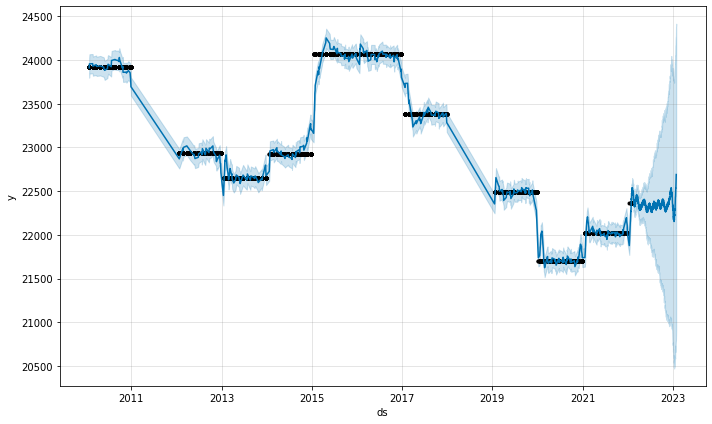

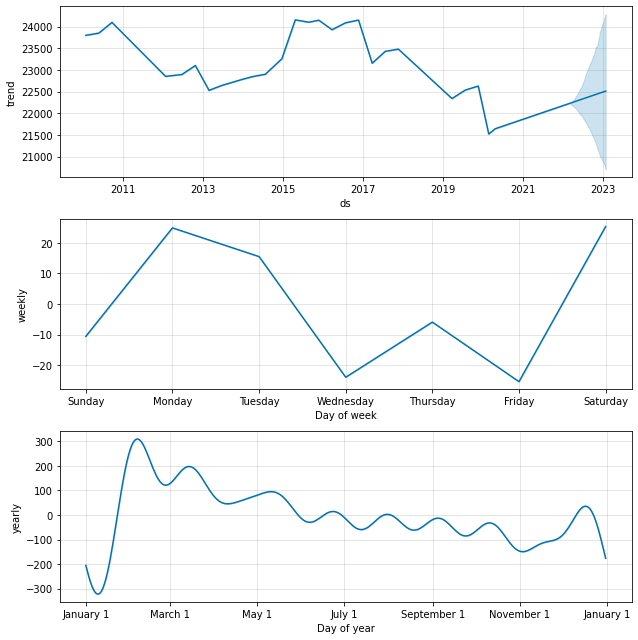

In [247]:
m_by_1_year, future_by_1_year, forecast_for_1_year, fig1, fig2 = future_preds(df_by_year,period=365)
forecast_for_1_year[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

18:02:07 - cmdstanpy - INFO - Chain [1] start processing
18:02:49 - cmdstanpy - INFO - Chain [1] done processing


ds          yhat    yhat_lower    yhat_upper
4114 2032-01-22  25263.666458 -42258.615424  93262.852136
4115 2032-01-23  25281.900376 -42189.064341  93336.082772
4116 2032-01-24  25370.660565 -42237.340896  93421.364855
4117 2032-01-25  25372.478145 -42239.487159  93436.844395
4118 2032-01-26  25444.937611 -42203.536831  93582.644123

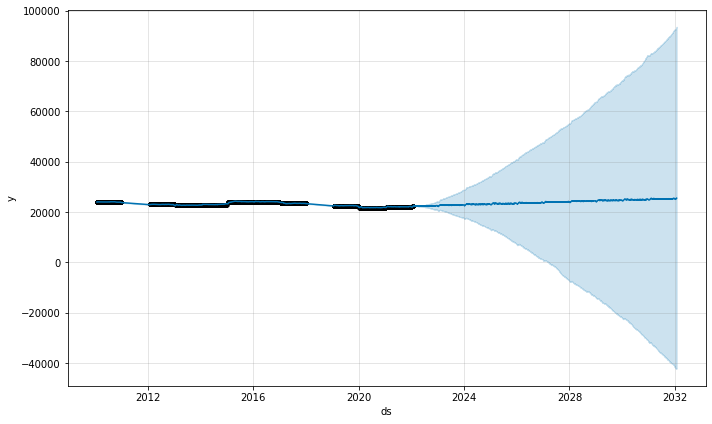

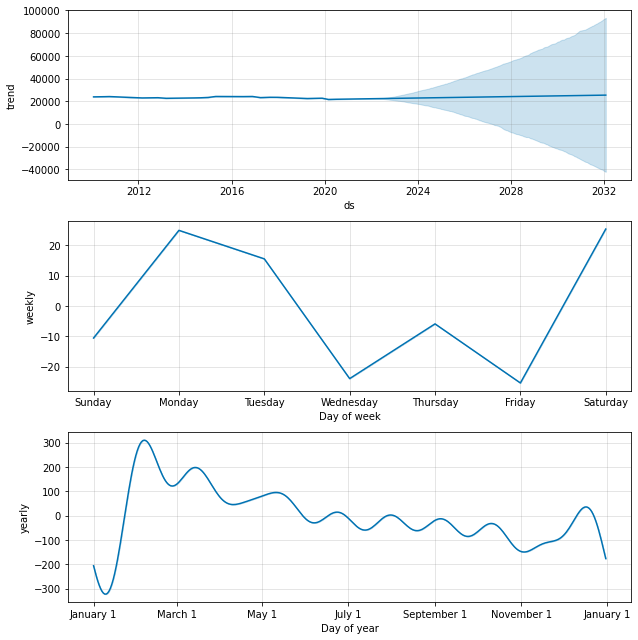

In [248]:
m_by_10_year, future_by_10_year, forecast_for_10_year, fig1, fig2 = future_preds(df_by_year,period=10*365)
forecast_for_10_year[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

18:32:47 - cmdstanpy - INFO - Chain [1] start processing
18:33:29 - cmdstanpy - INFO - Chain [1] done processing


ds          yhat     yhat_lower     yhat_upper
7764 2042-01-19  28316.265015 -159916.216693  220552.145138
7765 2042-01-20  28386.405674 -159776.148777  220631.265620
7766 2042-01-21  28413.273826 -159908.658859  220603.005435
7767 2042-01-22  28411.159977 -159792.878712  220852.854196
7768 2042-01-23  28467.134468 -159907.273303  220825.429762

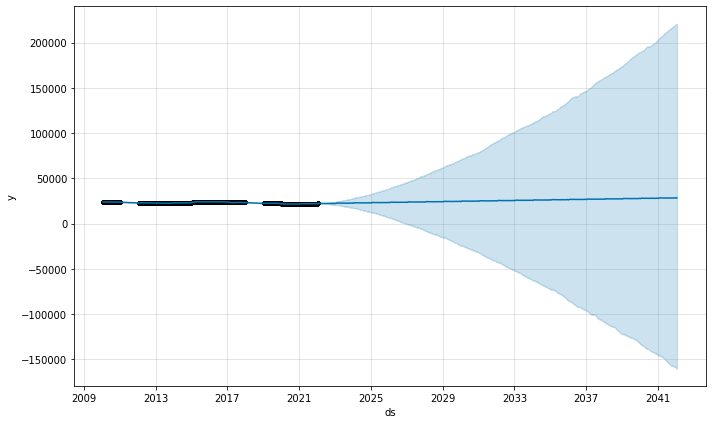

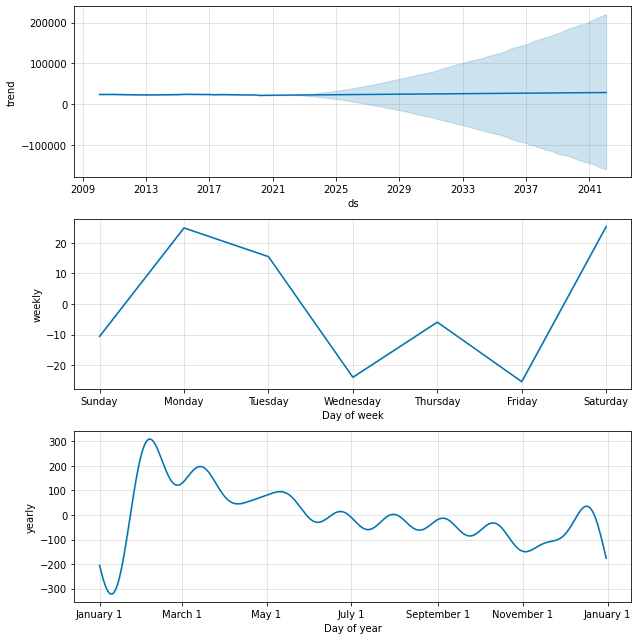

In [250]:
m_by_20_year, future_by_20_year, forecast_for_20_year, fig1, fig2 = future_preds(df_by_year,period=20*365)
forecast_for_20_year[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

### By Month

18:33:34 - cmdstanpy - INFO - Chain [1] start processing
18:33:59 - cmdstanpy - INFO - Chain [1] done processing


ds          yhat    yhat_lower    yhat_upper
495 2022-02-23  19934.070758  18749.555426  21246.445931
496 2022-02-24  19212.428106  18006.900953  20434.560641
497 2022-02-25  19342.145649  18000.843581  20574.313324
498 2022-02-26  19172.291358  17922.029723  20394.476878
499 2022-02-27  19584.359748  18322.531152  20936.112310

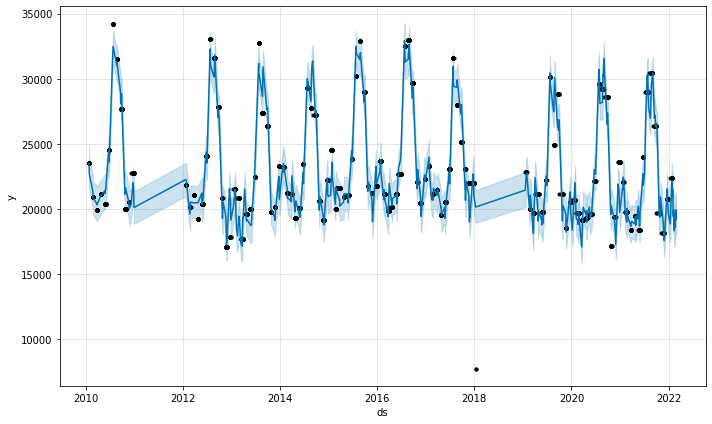

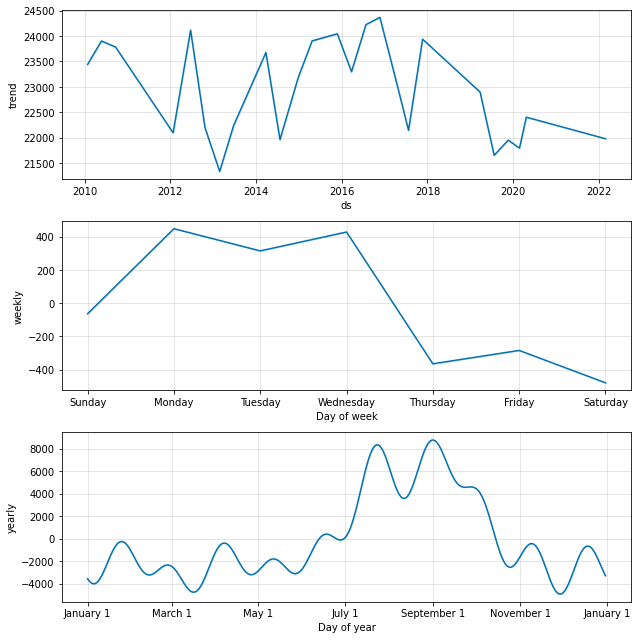

In [251]:
m_by_1_month, future_by_1_month, forecast_for_1_month, fig1, fig2 = future_preds(df_by_month,period=30)
forecast_for_1_month[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

18:34:00 - cmdstanpy - INFO - Chain [1] start processing
18:34:25 - cmdstanpy - INFO - Chain [1] done processing


ds          yhat    yhat_lower    yhat_upper
645 2022-07-23  29749.616604  27978.082392  31705.019986
646 2022-07-24  30187.087228  28414.475294  32066.815814
647 2022-07-25  30650.191066  28974.332872  32542.053046
648 2022-07-26  30400.948834  28606.455742  32125.484958
649 2022-07-27  30334.912995  28516.537674  32112.669297

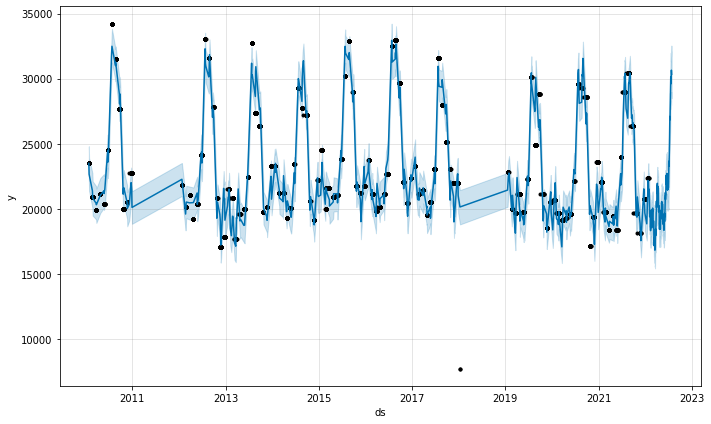

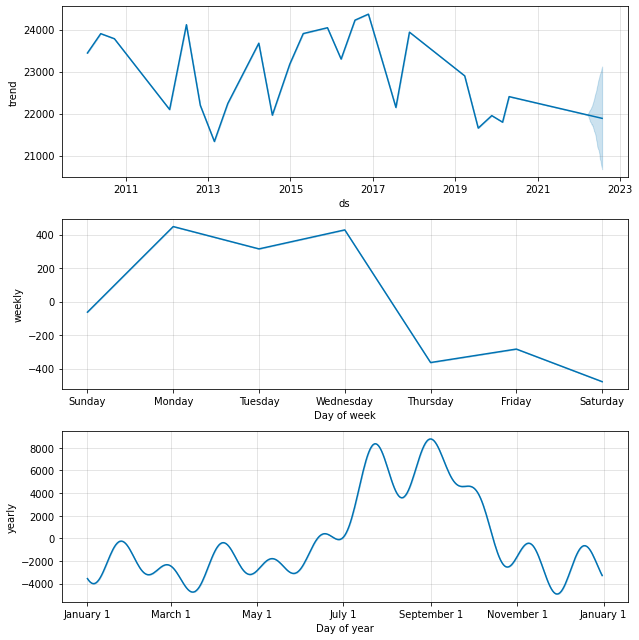

In [252]:
m_by_6_month, future_by_6_month, forecast_for_6_month, fig1, fig2 = future_preds(df_by_month,period=30*6)
forecast_for_6_month[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

18:34:28 - cmdstanpy - INFO - Chain [1] start processing
18:34:53 - cmdstanpy - INFO - Chain [1] done processing


ds          yhat    yhat_lower    yhat_upper
735 2022-10-21  19485.414962  16641.453002  22720.457458
736 2022-10-22  19092.412645  16087.061207  22211.815375
737 2022-10-23  19361.802432  16267.422714  22495.038161
738 2022-10-24  19781.254743  16841.759028  23140.804228
739 2022-10-25  19609.498193  16787.996587  22891.848206

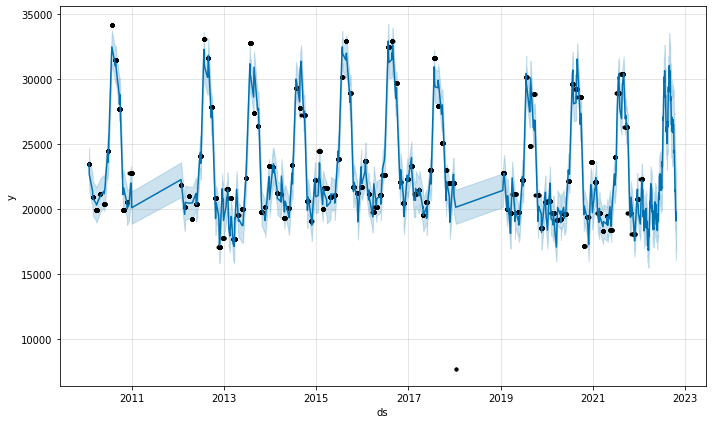

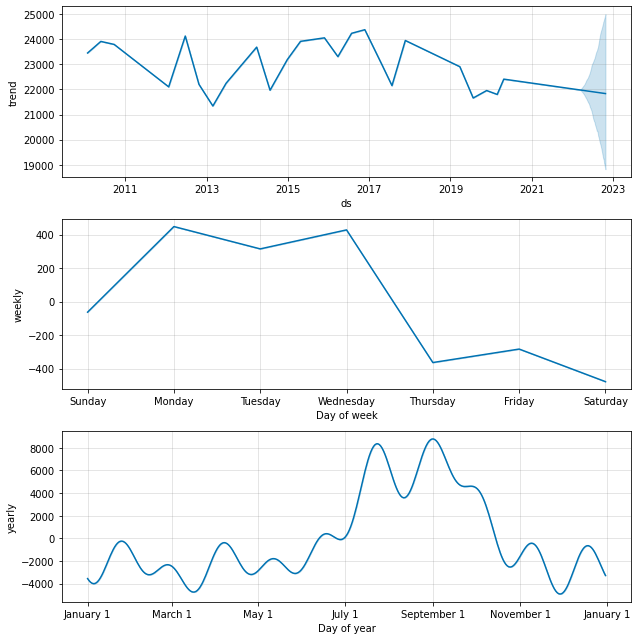

In [253]:
m_by_9_month, future_by_9_month, forecast_for_9_month, fig1, fig2 = future_preds(df_by_month,period=30*9)
forecast_for_9_month[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

### By Day

18:34:55 - cmdstanpy - INFO - Chain [1] start processing
18:34:56 - cmdstanpy - INFO - Chain [1] done processing


ds           yhat    yhat_lower     yhat_upper
567 2022-05-04   35539.880944   3634.139507   70312.670788
568 2022-05-05   34489.622840    119.537769   66515.808435
569 2022-05-06   33326.493610    342.524892   66198.249980
570 2022-05-07  102007.067052  68229.341670  135679.523064
571 2022-05-08  103205.664946  70605.483562  137087.699967

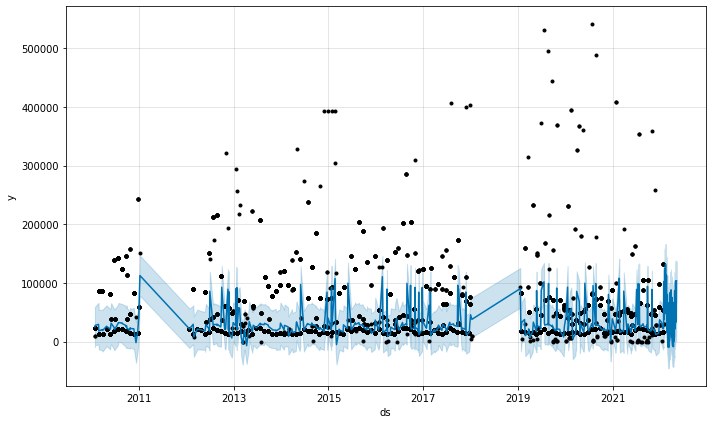

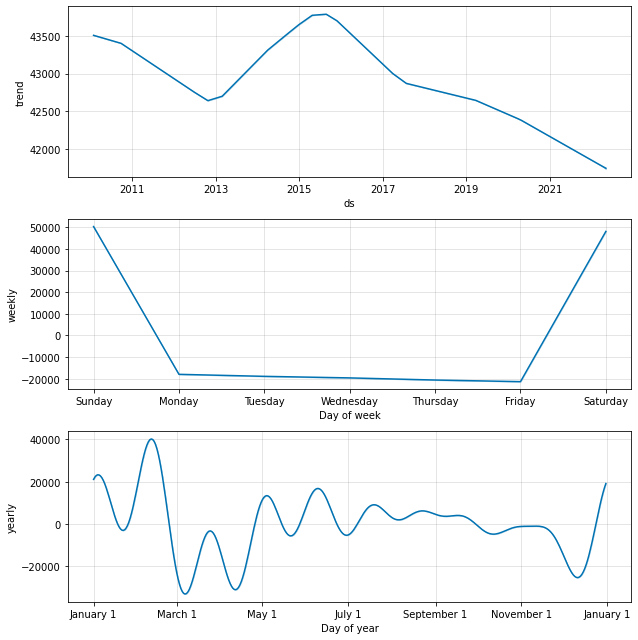

In [254]:
m_by_100_day, future_by_100_day, forecast_for_100_day, fig1, fig2 = future_preds(df_by_day,period=100)
forecast_for_100_day[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

18:34:58 - cmdstanpy - INFO - Chain [1] start processing
18:35:00 - cmdstanpy - INFO - Chain [1] done processing


ds          yhat    yhat_lower     yhat_upper
667 2022-08-12  23603.622780 -12036.294499   57752.455718
668 2022-08-13  93416.701776  57923.256307  127155.314402
669 2022-08-14  96050.486179  62101.495901  129827.315105
670 2022-08-15  28154.553591  -5134.972699   61668.457845
671 2022-08-16  27601.463280  -4824.839968   60399.952259

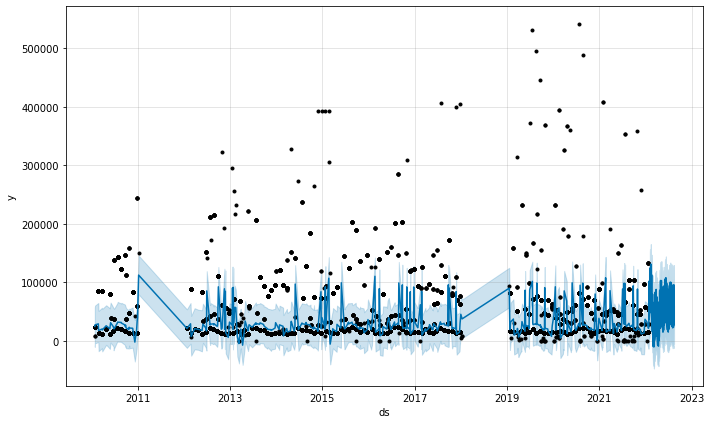

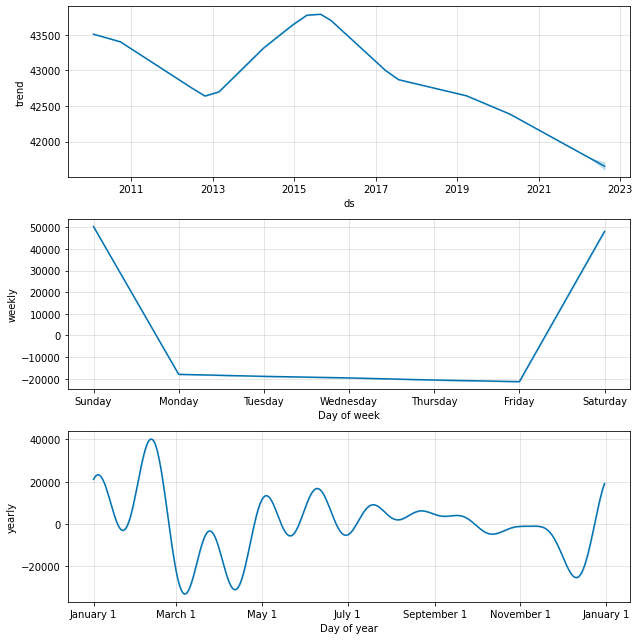

In [255]:
m_by_200_day, future_by_200_day, forecast_for_200_day, fig1, fig2 = future_preds(df_by_day,period=200)
forecast_for_200_day[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

18:35:02 - cmdstanpy - INFO - Chain [1] start processing
18:35:04 - cmdstanpy - INFO - Chain [1] done processing


ds          yhat    yhat_lower     yhat_upper
832 2023-01-24  20195.706272 -14604.515807   51062.537659
833 2023-01-25  20426.349859 -14330.201586   53412.517633
834 2023-01-26  20840.155361 -13106.740980   53393.619905
835 2023-01-27  21928.925796 -13296.778686   55023.200456
836 2023-01-28  93585.962810  58769.035977  126571.638529

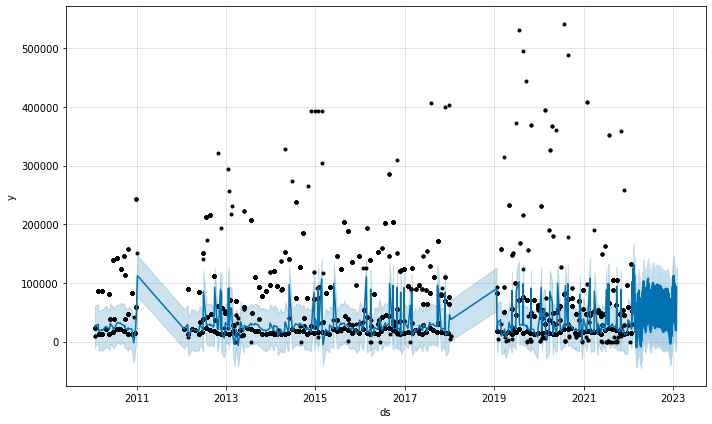

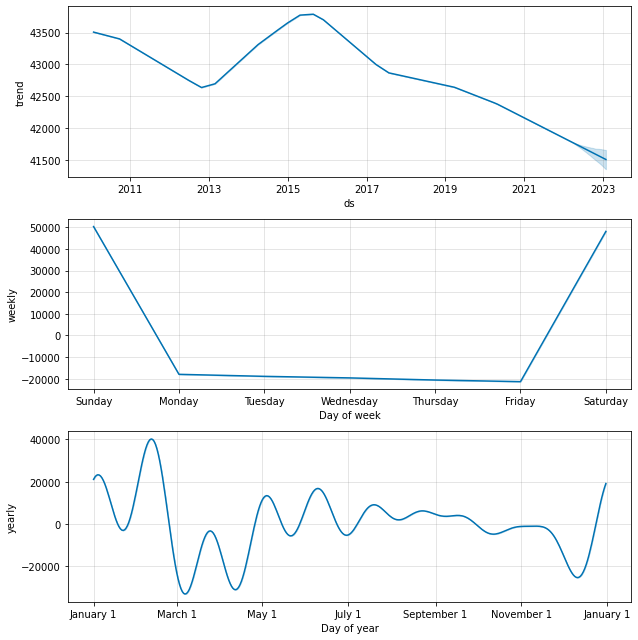

In [256]:
m_by_365_day, future_by_365_day, forecast_for_365_day, fig1, fig2 = future_preds(df_by_day,period=365)
forecast_for_365_day[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

## Step Three: Model Tuning

### Logistic Forecasting Growth

We will now look at the model forecasting in the case of adding a growth option. FBProphet considers three growth options - linear, logistic and flat. We have performed linear forecasting in the previous section, as it is the default. Now we will try logistic and flat.

In [257]:
def future_preds_logistic(df,period,cap,growth):
    if growth == 'logistic':
        df['cap'] = cap
    m = Prophet(growth=growth)
    m.fit(df)
    future = m.make_future_dataframe(period) #period is in units of days
    future['cap'] = cap
    forecast = m.predict(future)
    fig1 = m.plot(forecast);
    fig2 = m.plot_components(forecast);
    return (m, future, forecast, fig1, fig2) 

18:35:06 - cmdstanpy - INFO - Chain [1] start processing
18:35:08 - cmdstanpy - INFO - Chain [1] done processing


ds          yhat    yhat_lower    yhat_upper
567 2022-05-04  26983.701272 -11754.052539  62297.488677
568 2022-05-05  25527.162131 -12616.743769  61700.274712
569 2022-05-06  23870.180596 -13355.158124  61705.947235
570 2022-05-07 -38035.461630 -75606.306774  -5714.764223
571 2022-05-08 -16664.284832 -50841.275574  22588.739769

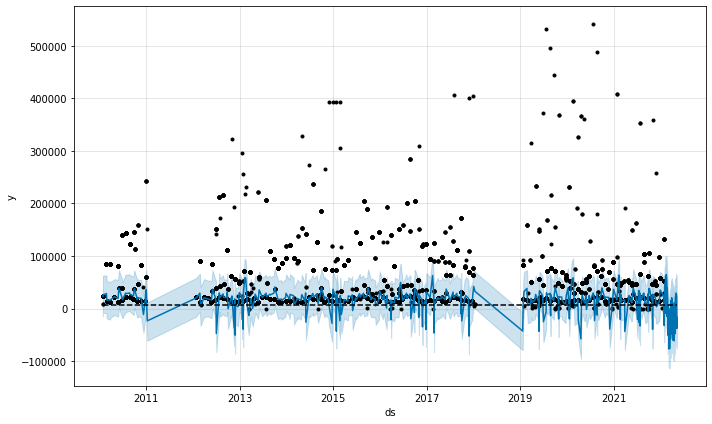

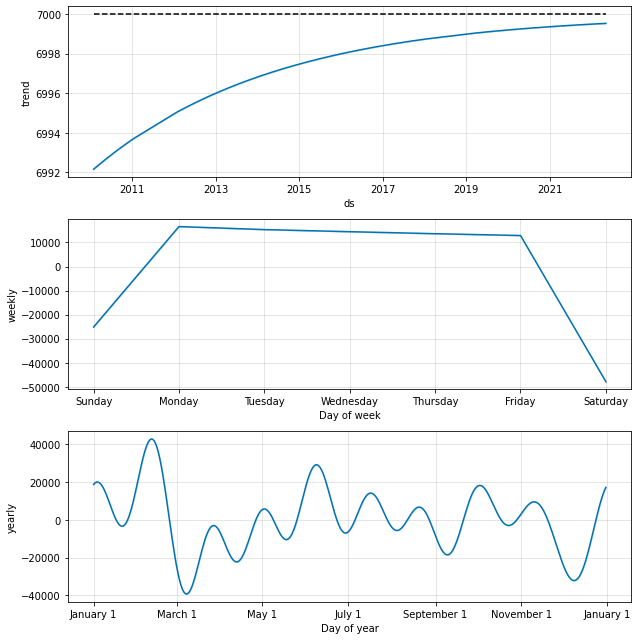

In [258]:
m_by_100_day_logistic, future_by_100_day_logistic, forecast_for_100_day_logistic, fig1, fig2 = future_preds_logistic(df_by_day,period=100,cap=7000,growth='logistic')
forecast_for_100_day_logistic[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

18:35:16 - cmdstanpy - INFO - Chain [1] start processing
18:35:18 - cmdstanpy - INFO - Chain [1] done processing


ds          yhat    yhat_lower    yhat_upper
567 2022-05-04  26983.701272 -11754.052539  62297.488677
568 2022-05-05  25527.162131 -12616.743769  61700.274712
569 2022-05-06  23870.180596 -13355.158124  61705.947235
570 2022-05-07 -38035.461630 -75606.306774  -5714.764223
571 2022-05-08 -16664.284832 -50841.275574  22588.739769

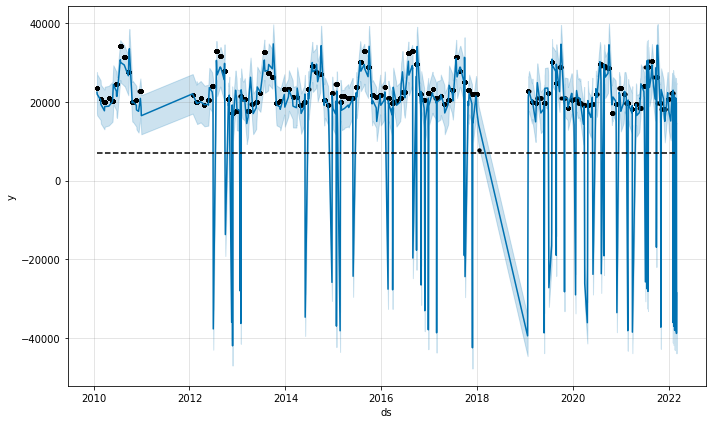

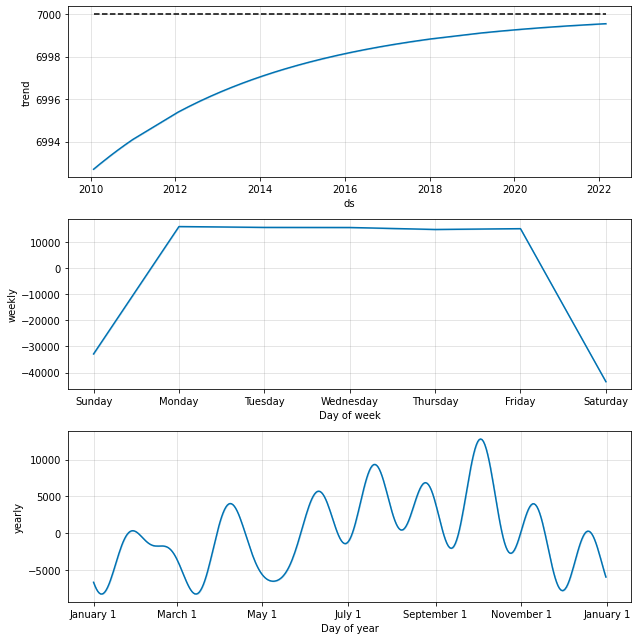

In [259]:
m_by_1_month_logistic, future_by_1_month_logistic, forecast_for_1_month_logistic, fig1, fig2 = future_preds_logistic(df_by_month,period=30,cap=7000,growth='logistic')
forecast_for_100_day_logistic[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

18:35:25 - cmdstanpy - INFO - Chain [1] start processing
18:35:28 - cmdstanpy - INFO - Chain [1] done processing


ds          yhat    yhat_lower    yhat_upper
567 2022-05-04  26983.701272 -11754.052539  62297.488677
568 2022-05-05  25527.162131 -12616.743769  61700.274712
569 2022-05-06  23870.180596 -13355.158124  61705.947235
570 2022-05-07 -38035.461630 -75606.306774  -5714.764223
571 2022-05-08 -16664.284832 -50841.275574  22588.739769

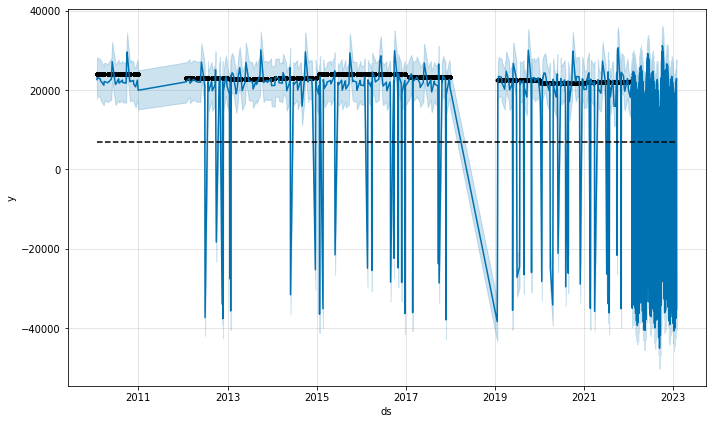

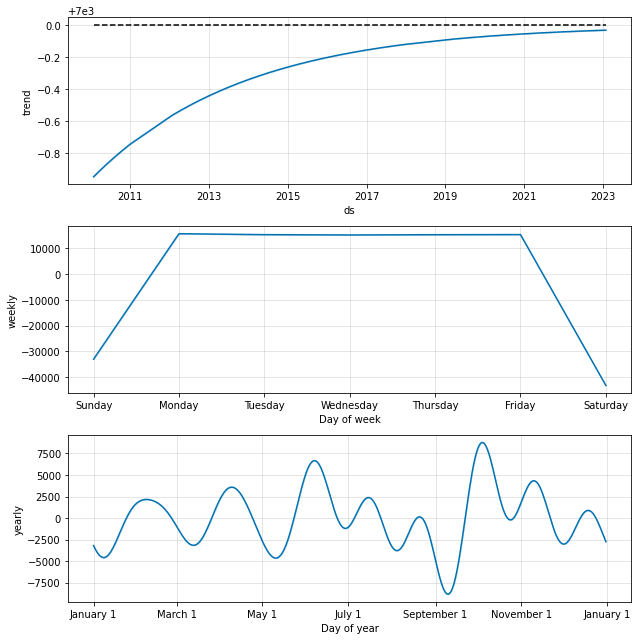

In [260]:
m_by_1_year_logistic, future_by_1_year_logistic, forecast_for_1_year_logistic, fig1, fig2 = future_preds_logistic(df_by_year,period=365,cap=7000,growth='logistic')
forecast_for_100_day_logistic[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

Now we will look at flat forecasting growth.

18:35:38 - cmdstanpy - INFO - Chain [1] start processing
18:35:38 - cmdstanpy - INFO - Chain [1] done processing


ds          yhat    yhat_lower    yhat_upper
567 2022-05-04  26983.701272 -11754.052539  62297.488677
568 2022-05-05  25527.162131 -12616.743769  61700.274712
569 2022-05-06  23870.180596 -13355.158124  61705.947235
570 2022-05-07 -38035.461630 -75606.306774  -5714.764223
571 2022-05-08 -16664.284832 -50841.275574  22588.739769

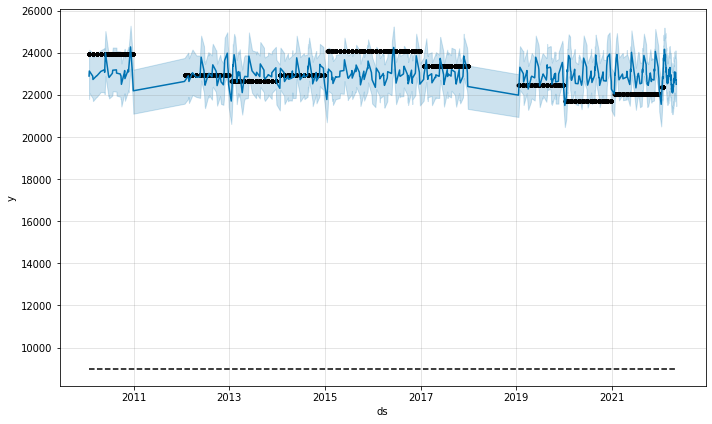

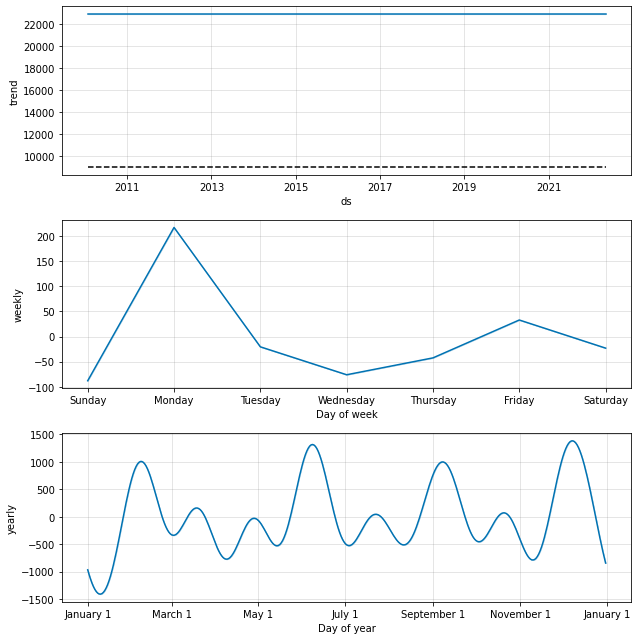

In [261]:
m_by_100_day_flat, future_by_100_day_flat, forecast_for_100_day_flat, fig1, fig2 = future_preds_logistic(df_by_year,period=100,cap=9000,growth='flat')
forecast_for_100_day_logistic[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

18:35:40 - cmdstanpy - INFO - Chain [1] start processing
18:35:41 - cmdstanpy - INFO - Chain [1] done processing


ds          yhat    yhat_lower    yhat_upper
567 2022-05-04  26983.701272 -11754.052539  62297.488677
568 2022-05-05  25527.162131 -12616.743769  61700.274712
569 2022-05-06  23870.180596 -13355.158124  61705.947235
570 2022-05-07 -38035.461630 -75606.306774  -5714.764223
571 2022-05-08 -16664.284832 -50841.275574  22588.739769

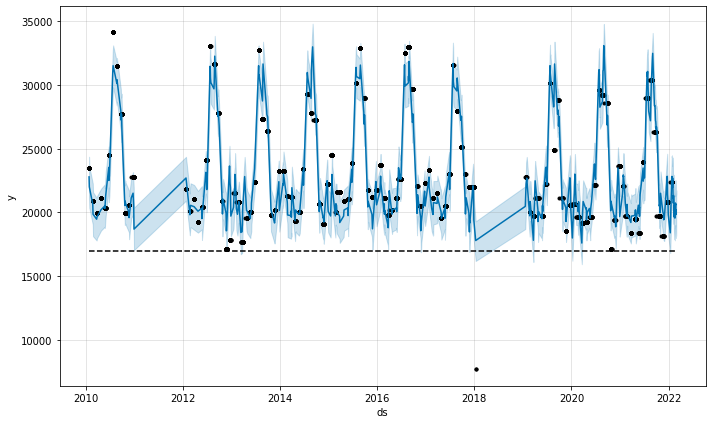

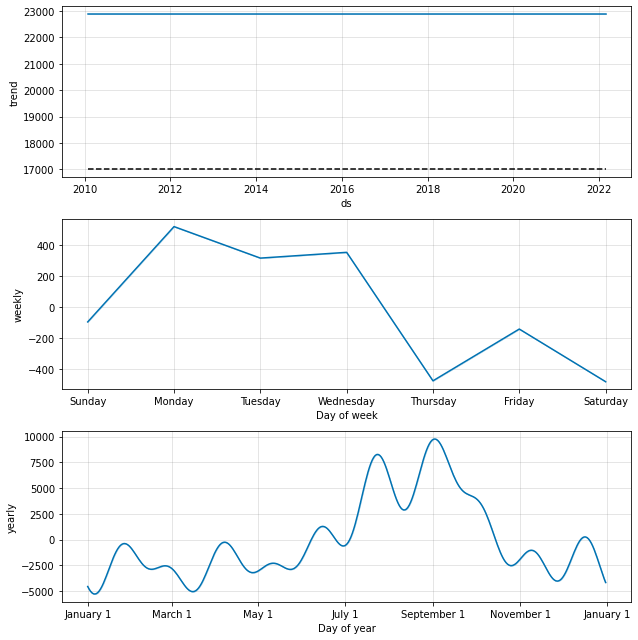

In [262]:
m_by_1_month_flat, future_by_1_month_flat, forecast_for_1_month_flat, fig1, fig2 = future_preds_logistic(df_by_month,period=30,cap=17000,growth='flat')
forecast_for_100_day_logistic[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

18:35:43 - cmdstanpy - INFO - Chain [1] start processing
18:35:43 - cmdstanpy - INFO - Chain [1] done processing


ds          yhat    yhat_lower    yhat_upper
567 2022-05-04  26983.701272 -11754.052539  62297.488677
568 2022-05-05  25527.162131 -12616.743769  61700.274712
569 2022-05-06  23870.180596 -13355.158124  61705.947235
570 2022-05-07 -38035.461630 -75606.306774  -5714.764223
571 2022-05-08 -16664.284832 -50841.275574  22588.739769

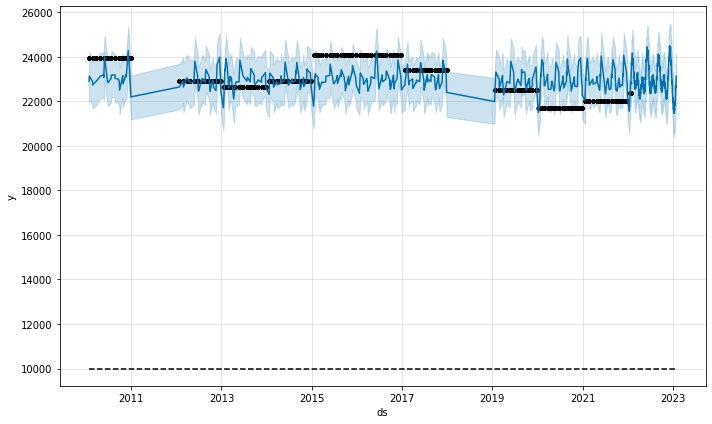

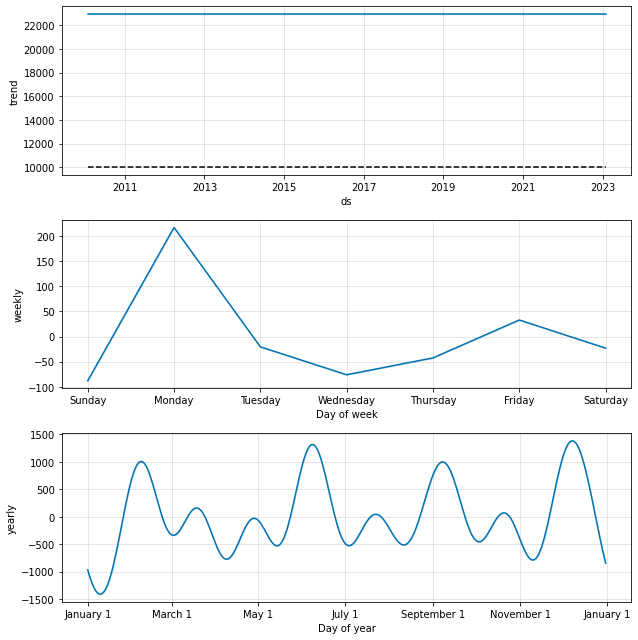

In [263]:
m_by_1_year_flat, future_by_1_year_flat, forecast_for_1_year_flat, fig1, fig2 = future_preds_logistic(df_by_year,period=365,cap=10000,growth='flat')
forecast_for_100_day_logistic[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

### Seasonality 

Now we will add seasonality.

In [264]:
def future_preds_seasonality(df,period,growth='linear',cap=None,daily_seasonality=False,weekly_seasonality=False,
                            yearly_seasonality=False,name=None,period_for_seasonality=None,fourier_order=None,
                            changepoint_prior_scale=1,n_changepoints=30):
    if growth == 'logistic':
        df['cap'] = cap                        
    m = Prophet(growth,daily_seasonality=daily_seasonality,weekly_seasonality=weekly_seasonality,
                yearly_seasonality=yearly_seasonality,
                changepoint_prior_scale=changepoint_prior_scale,
                n_changepoints=n_changepoints)
    m.add_seasonality(name,period_for_seasonality,fourier_order)
    m.add_country_holidays(country_name='US')
    m.fit(df)
    future = m.make_future_dataframe(period) #period is in units of days
    forecast = m.predict(future)
    fig1 = m.plot(forecast);
    fig2 = m.plot_components(forecast);
    return (forecast)

18:35:46 - cmdstanpy - INFO - Chain [1] start processing
18:35:51 - cmdstanpy - INFO - Chain [1] done processing


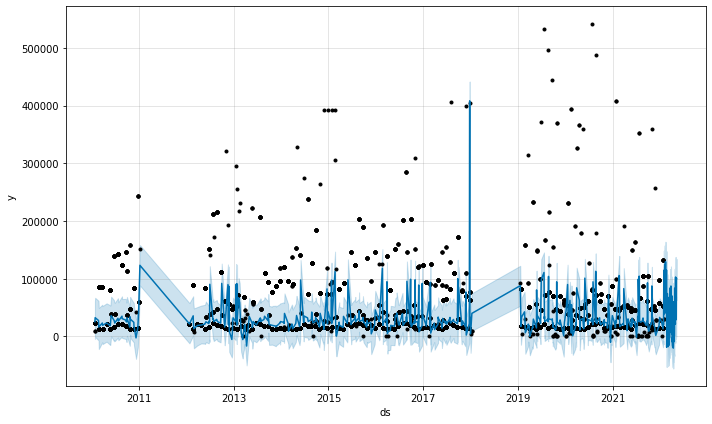

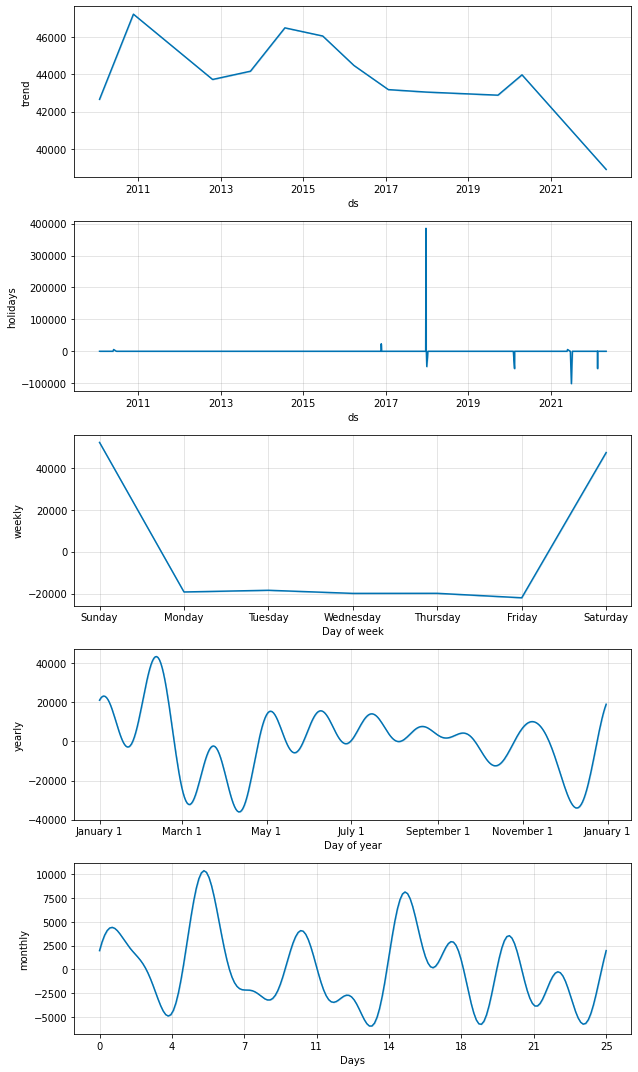

In [265]:
forecast_for_100_day_seasonality = future_preds_seasonality(df_by_day,period=100,weekly_seasonality=True,
                            yearly_seasonality=10,name='monthly',period_for_seasonality=25,fourier_order=10,
                            changepoint_prior_scale=1,n_changepoints=10)

18:35:54 - cmdstanpy - INFO - Chain [1] start processing
18:35:57 - cmdstanpy - INFO - Chain [1] done processing


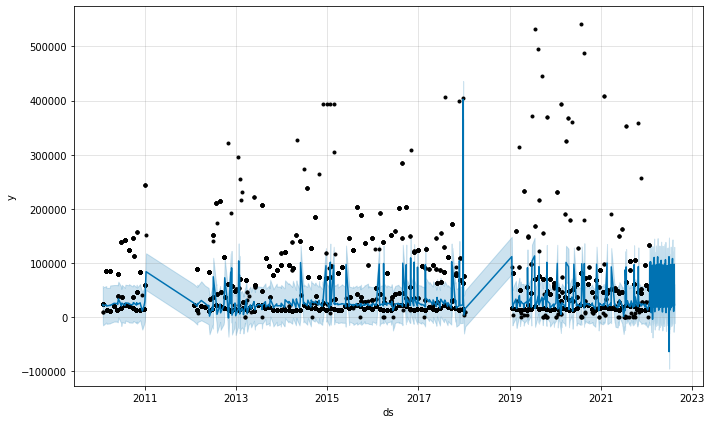

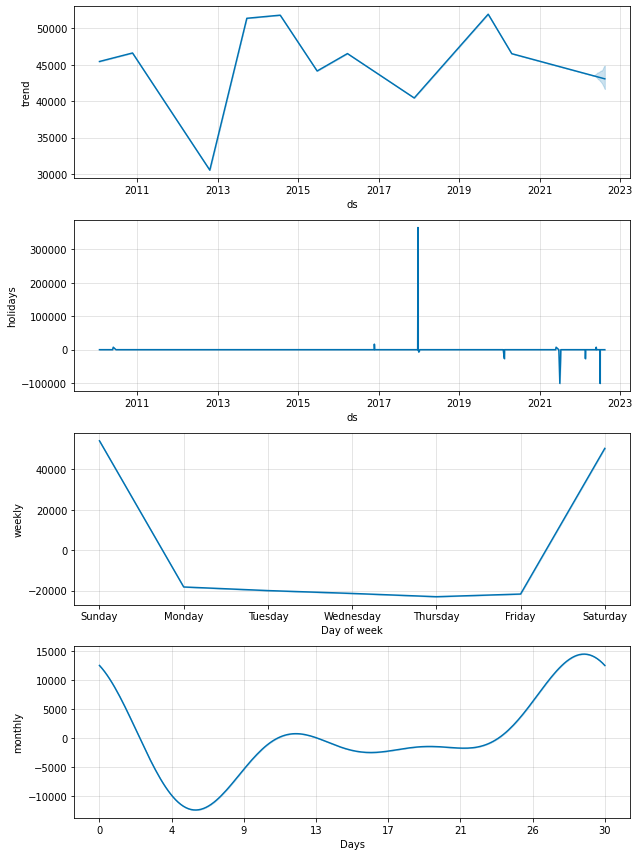

In [266]:
forecast_for_200_day_seasonality = future_preds_seasonality(df_by_day,period=200,weekly_seasonality=True,
                            yearly_seasonality=False,name='monthly',period_for_seasonality=30,fourier_order=3,
                            changepoint_prior_scale=1,n_changepoints=10)

18:36:01 - cmdstanpy - INFO - Chain [1] start processing
18:36:08 - cmdstanpy - INFO - Chain [1] done processing


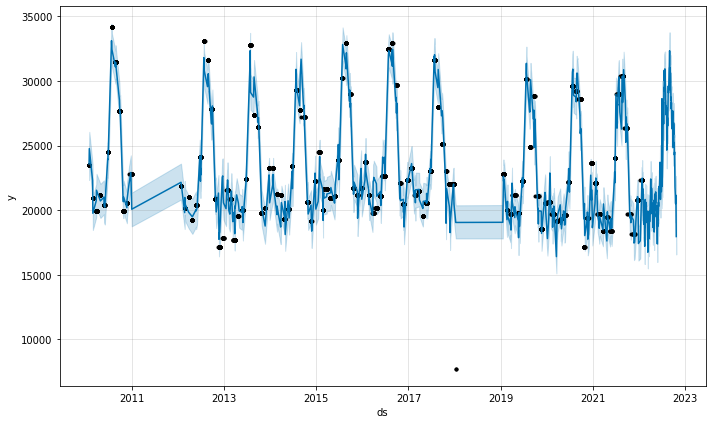

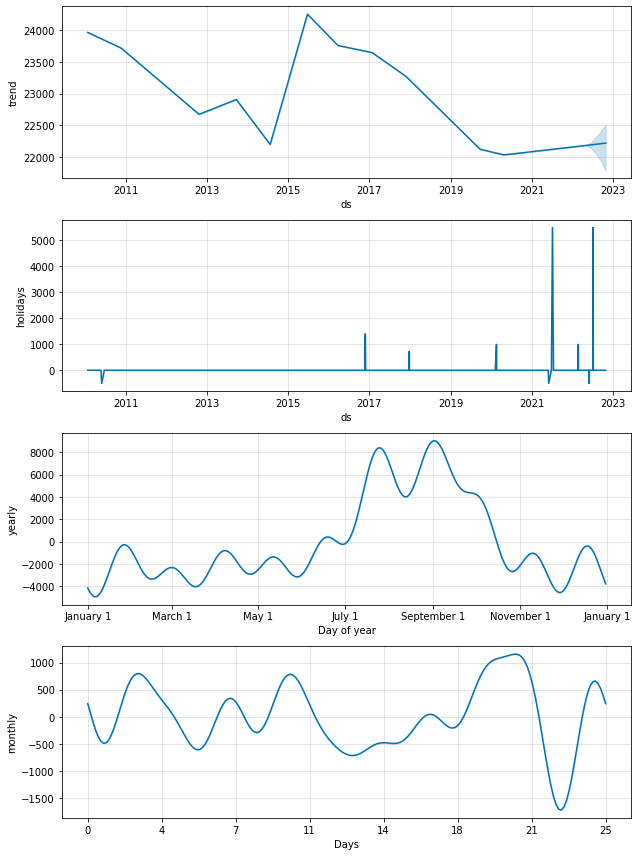

In [267]:
forecast_for_9_month_seasonality = future_preds_seasonality(df_by_month,period=30*9,weekly_seasonality=False,
                            yearly_seasonality=True,name='monthly',period_for_seasonality=25,fourier_order=10,
                            changepoint_prior_scale=1,n_changepoints=10)

18:36:11 - cmdstanpy - INFO - Chain [1] start processing
18:36:20 - cmdstanpy - INFO - Chain [1] done processing


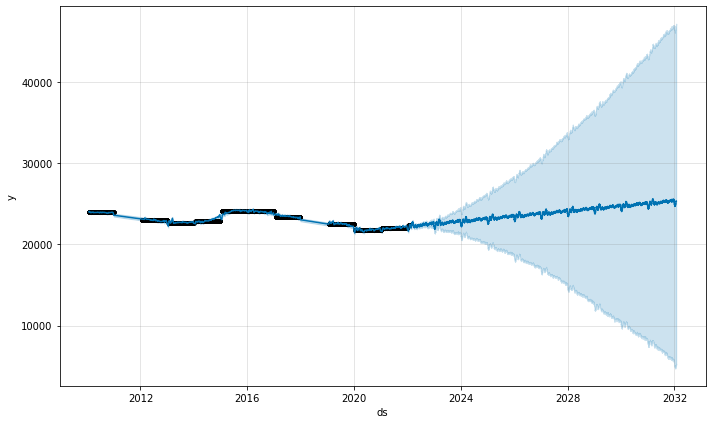

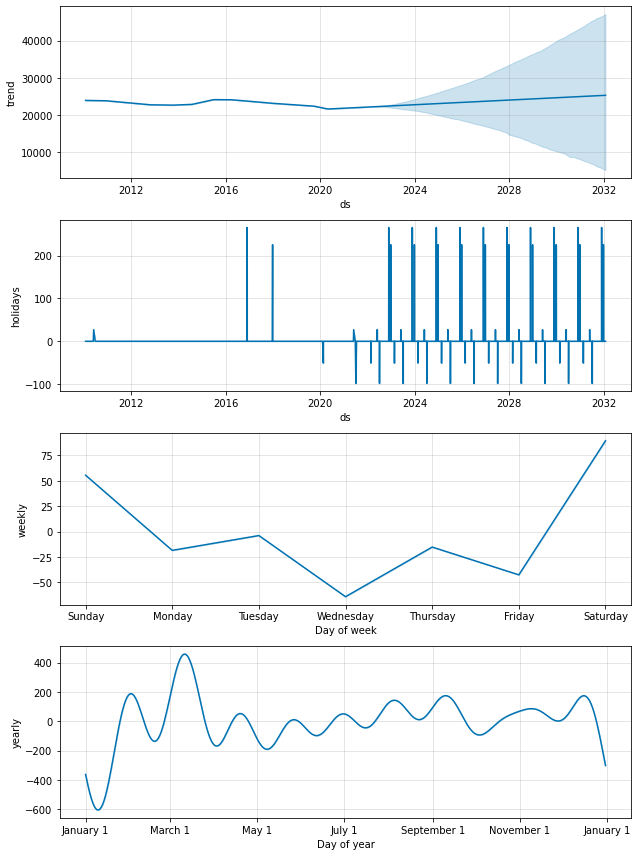

In [268]:
forecast_for_10_year_seasonality = future_preds_seasonality(df_by_year,period=365*10,weekly_seasonality=True,
                            yearly_seasonality=True,name='yearly',period_for_seasonality=25,fourier_order=10,
                            changepoint_prior_scale=1,n_changepoints=10)

We will now evaluate hyperparamater tuning options through cross-validatation.

In [269]:
def hyperparamter_tuning(df, param_grid, cap,
                        initial='730 days', period='180 days', horizon='365 days',
                        parallel='dask',growth='linear',seasonality=False,country_holidays=False,
                        name=None, period_for_seasonality=None, fourier_order=None):

    # Generate all combinations of parameters
    all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
    mapes = []  # Store the RMSEs for each params here
    final_df_cv = pd.DataFrame()
    final_df_p = pd.DataFrame()

    if growth == 'logistic':
        df['cap'] = cap 

    # Use cross validation to evaluate all parameters
    for params in all_params:
        m = Prophet(**params)

        if seasonality == True:
            m.add_seasonality(name,period_for_seasonality,fourier_order)
        if country_holidays == True:
            m.add_country_holidays(country_name='US')

        m.fit(df)  # Fit model with given params
        df_cv = cross_validation(m, initial=initial, period=period, horizon=horizon, parallel=parallel)
        df_p = performance_metrics(df_cv, rolling_window=1)
        mapes.append(df_p['rmse'].values[0])
        final_df_cv = pd.concat([final_df_cv, df_cv])
        final_df_p = pd.concat([final_df_p, df_p])

    # Find the best parameters
    tuning_results = pd.DataFrame(all_params)
    tuning_results['rmse'] = mapes

    best_params = all_params[np.argmin(mapes)]

    return(m, final_df_cv, final_df_p, tuning_results, best_params)

In [270]:
client = Client()  # connect to the cluster

param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0]
}

m, df_cv, df_p, tuning_results, best_params = hyperparamter_tuning(df, param_grid, cap=9000,
                        initial='730 days', period='180 days', horizon='365 days',
                        parallel='dask',growth='logistic',seasonality=True,country_holidays=True,
                        name='yearly', period_for_seasonality=365, fourier_order=10)  

client.close()          

18:36:25 - cmdstanpy - INFO - Chain [1] start processing
18:36:28 - cmdstanpy - INFO - Chain [1] done processing
18:36:30 - cmdstanpy - INFO - Chain [1] start processing
18:36:30 - cmdstanpy - INFO - Chain [1] start processing
18:36:30 - cmdstanpy - INFO - Chain [1] done processing
18:36:31 - cmdstanpy - INFO - Chain [1] done processing
18:36:31 - cmdstanpy - INFO - Chain [1] start processing
18:36:31 - cmdstanpy - INFO - Chain [1] start processing
18:36:31 - cmdstanpy - INFO - Chain [1] done processing
18:36:31 - cmdstanpy - INFO - Chain [1] done processing
18:36:34 - cmdstanpy - INFO - Chain [1] start processing
18:36:34 - cmdstanpy - INFO - Chain [1] start processing
18:36:34 - cmdstanpy - INFO - Chain [1] start processing
18:36:35 - cmdstanpy - INFO - Chain [1] done processing
18:36:35 - cmdstanpy - INFO - Chain [1] start processing
18:36:35 - cmdstanpy - INFO - Chain [1] done processing
18:36:35 - cmdstanpy - INFO - Chain [1] done processing
18:36:35 - cmdstanpy - INFO - Chain [1]

In [271]:
print(best_params)

{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0}


In [272]:
df_cv

ds          yhat    yhat_lower     yhat_upper       y     cutoff
0     2012-03-26  76567.551490  -1313.412873  157219.837008      47 2012-03-16
1     2012-03-26  76567.551490    629.988902  155045.708154     810 2012-03-16
2     2012-03-26  76567.551490   -982.197676  154333.008773    8480 2012-03-16
3     2012-03-26  76567.551490  -4086.113962  153099.867220      86 2012-03-16
4     2012-03-26  76567.551490  -3899.031001  148478.769487   33280 2012-03-16
...          ...           ...           ...            ...     ...        ...
36213 2022-01-26  24227.419851 -46692.052497   96557.282654   33600 2021-01-28
36214 2022-01-26  24227.419851 -49219.675281   93542.738380   29680 2021-01-28
36215 2022-01-26  24227.419851 -46493.279313   96751.145370  126680 2021-01-28
36216 2022-01-28  27579.764317 -43128.960234  102337.364838   36400 2021-01-28
36217 2022-01-28  27579.764317 -39461.097766   97627.456383   22480 2021-01-28

[579488 rows x 6 columns]

In [273]:
df_p.sort_values('smape',ascending=False)

horizon           mse           rmse           mae      mdape     smape  \
0 365 days  1.211133e+10  110051.509233  55409.327573  16.376177  1.496472   
0 365 days  1.424924e+10  119370.188299  57196.022804  16.525073  1.495666   
0 365 days  4.190122e+09   64731.149537  38979.434376  15.033497  1.480845   
0 365 days  4.306419e+09   65623.307652  36804.975255  14.327362  1.475530   
0 365 days  4.249479e+09   65188.031669  36797.407211  14.504828  1.471239   
0 365 days  4.253696e+09   65220.361759  36791.369237  14.439989  1.470999   
0 365 days  4.375201e+09   66145.303421  37256.380998  15.316711  1.467308   
0 365 days  4.305574e+09   65616.873203  37076.275926  15.294445  1.467192   
0 365 days  4.219871e+09   64960.535798  36804.903130  15.275935  1.466785   
0 365 days  3.965613e+09   62973.115902  34962.687303  14.193991  1.463653   
0 365 days  4.040569e+09   63565.470685  35106.611183  14.068954  1.463630   
0 365 days  3.256459e+09   57065.391979  31366.480236  13.360279  1.462981   
0 365 days  3.480812e+09   58998.409183  34363.518849  15.277460  1.458926   
0 365 days  3.426242e+09   58534.110946  33366.758225  15.162066  1.456087   
0 365 days  3.394857e+09   58265.402531  32810.029434  14.588386  1.454253   
0 365 days  3.284361e+09   57309.341718  31901.124369  14.165607  1.453259   

   coverage  
0  0.829919  
0  0.832652  
0  0.872826  
0  0.894748  
0  0.895632  
0  0.895881  
0  0.896295  
0  0.897730  
0  0.900823  
0  0.910376  
0  0.911122  
0  0.936164  
0  0.919708  
0  0.923574  
0  0.924540  
0  0.927716

### Changepoints

We will now add changepoints to some of the models.

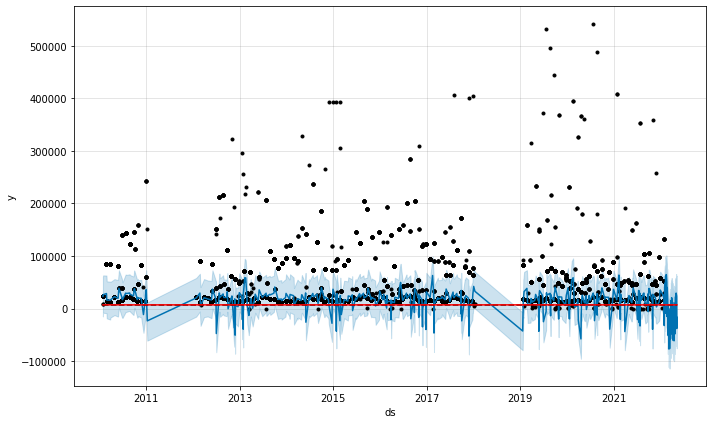

In [274]:
fig = m_by_100_day_logistic.plot(forecast_for_100_day_logistic)
a = add_changepoints_to_plot(fig.gca(), m_by_100_day_logistic, forecast_for_100_day_logistic)

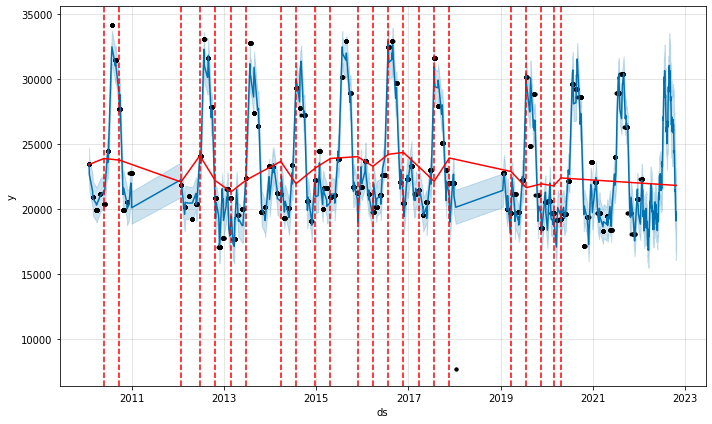

In [275]:
fig = m_by_9_month.plot(forecast_for_9_month)
a = add_changepoints_to_plot(fig.gca(), m_by_9_month, forecast_for_9_month)

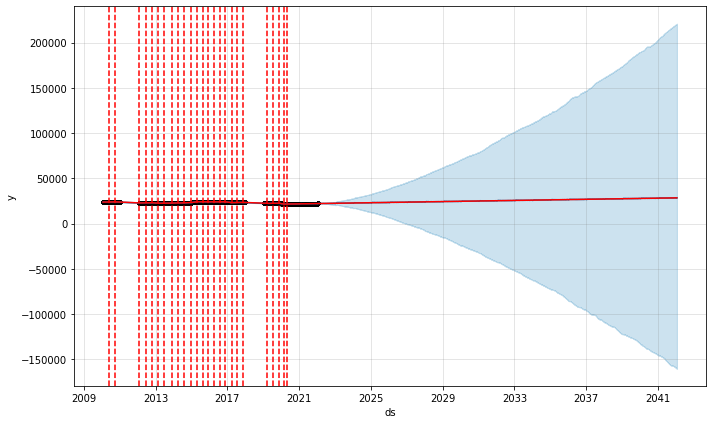

In [276]:
fig = m_by_20_year.plot(forecast_for_20_year)
a = add_changepoints_to_plot(fig.gca(), m_by_20_year, forecast_for_20_year)

## Step Four: Model Evaluation

In this section, we use cross-validation to compare some key metrics of the models.

In [277]:
client = Client()  # connect to the cluster
m = Prophet()
m.fit(df_by_year);
df_cv = cross_validation(m, initial='730 days', period='180 days', horizon='365 days', parallel='dask');
df_p_by_year = performance_metrics(df_cv);
client.close()   

18:47:36 - cmdstanpy - INFO - Chain [1] start processing
18:48:23 - cmdstanpy - INFO - Chain [1] done processing
18:48:26 - cmdstanpy - INFO - Chain [1] start processing
18:48:26 - cmdstanpy - INFO - Chain [1] start processing
18:48:26 - cmdstanpy - INFO - Chain [1] start processing
18:48:26 - cmdstanpy - INFO - Chain [1] start processing
18:48:31 - cmdstanpy - INFO - Chain [1] start processing
18:48:31 - cmdstanpy - INFO - Chain [1] start processing
18:48:31 - cmdstanpy - INFO - Chain [1] start processing
18:48:32 - cmdstanpy - INFO - Chain [1] start processing
18:48:32 - cmdstanpy - INFO - Chain [1] start processing
18:48:32 - cmdstanpy - INFO - Chain [1] start processing
18:48:33 - cmdstanpy - INFO - Chain [1] start processing
18:48:33 - cmdstanpy - INFO - Chain [1] start processing
18:48:33 - cmdstanpy - INFO - Chain [1] start processing
18:48:33 - cmdstanpy - INFO - Chain [1] start processing
18:48:33 - cmdstanpy - INFO - Chain [1] start processing
18:48:34 - cmdstanpy - INFO - Ch

In [278]:
client = Client()  # connect to the cluster
m = Prophet()
m.fit(df_by_month)
df_cv = cross_validation(m, initial='730 days', period='180 days', horizon='365 days', parallel='dask')
df_p_by_month = performance_metrics(df_cv)
client.close()   

18:54:23 - cmdstanpy - INFO - Chain [1] start processing
18:54:49 - cmdstanpy - INFO - Chain [1] done processing
18:54:50 - cmdstanpy - INFO - Chain [1] start processing
18:54:50 - cmdstanpy - INFO - Chain [1] start processing
18:54:51 - cmdstanpy - INFO - Chain [1] start processing
18:54:51 - cmdstanpy - INFO - Chain [1] start processing
18:54:54 - cmdstanpy - INFO - Chain [1] start processing
18:54:54 - cmdstanpy - INFO - Chain [1] start processing
18:54:54 - cmdstanpy - INFO - Chain [1] start processing
18:54:55 - cmdstanpy - INFO - Chain [1] start processing
18:54:56 - cmdstanpy - INFO - Chain [1] start processing
18:54:56 - cmdstanpy - INFO - Chain [1] start processing
18:54:56 - cmdstanpy - INFO - Chain [1] start processing
18:54:56 - cmdstanpy - INFO - Chain [1] start processing
18:54:57 - cmdstanpy - INFO - Chain [1] start processing
18:54:59 - cmdstanpy - INFO - Chain [1] start processing
18:55:00 - cmdstanpy - INFO - Chain [1] start processing
18:55:00 - cmdstanpy - INFO - Ch

In [279]:
client = Client()  # connect to the cluster
m = Prophet()
m.fit(df_by_day)
df_cv = cross_validation(m, initial='730 days', period='180 days', horizon='365 days', parallel='dask')
df_p_by_day = performance_metrics(df_cv)
client.close()   

19:00:43 - cmdstanpy - INFO - Chain [1] start processing
19:00:45 - cmdstanpy - INFO - Chain [1] done processing
19:00:47 - cmdstanpy - INFO - Chain [1] start processing
19:00:47 - cmdstanpy - INFO - Chain [1] start processing
19:00:47 - cmdstanpy - INFO - Chain [1] start processing
19:00:47 - cmdstanpy - INFO - Chain [1] start processing
19:00:48 - cmdstanpy - INFO - Chain [1] done processing
19:00:49 - cmdstanpy - INFO - Chain [1] done processing
19:00:49 - cmdstanpy - INFO - Chain [1] done processing
19:00:50 - cmdstanpy - INFO - Chain [1] done processing
19:00:50 - cmdstanpy - INFO - Chain [1] start processing
19:00:50 - cmdstanpy - INFO - Chain [1] start processing
19:00:51 - cmdstanpy - INFO - Chain [1] start processing
19:00:51 - cmdstanpy - INFO - Chain [1] start processing
19:00:51 - cmdstanpy - INFO - Chain [1] start processing
19:00:51 - cmdstanpy - INFO - Chain [1] start processing
19:00:51 - cmdstanpy - INFO - Chain [1] done processing
19:00:52 - cmdstanpy - INFO - Chain [

Text(0, 0.5, 'MAPE')

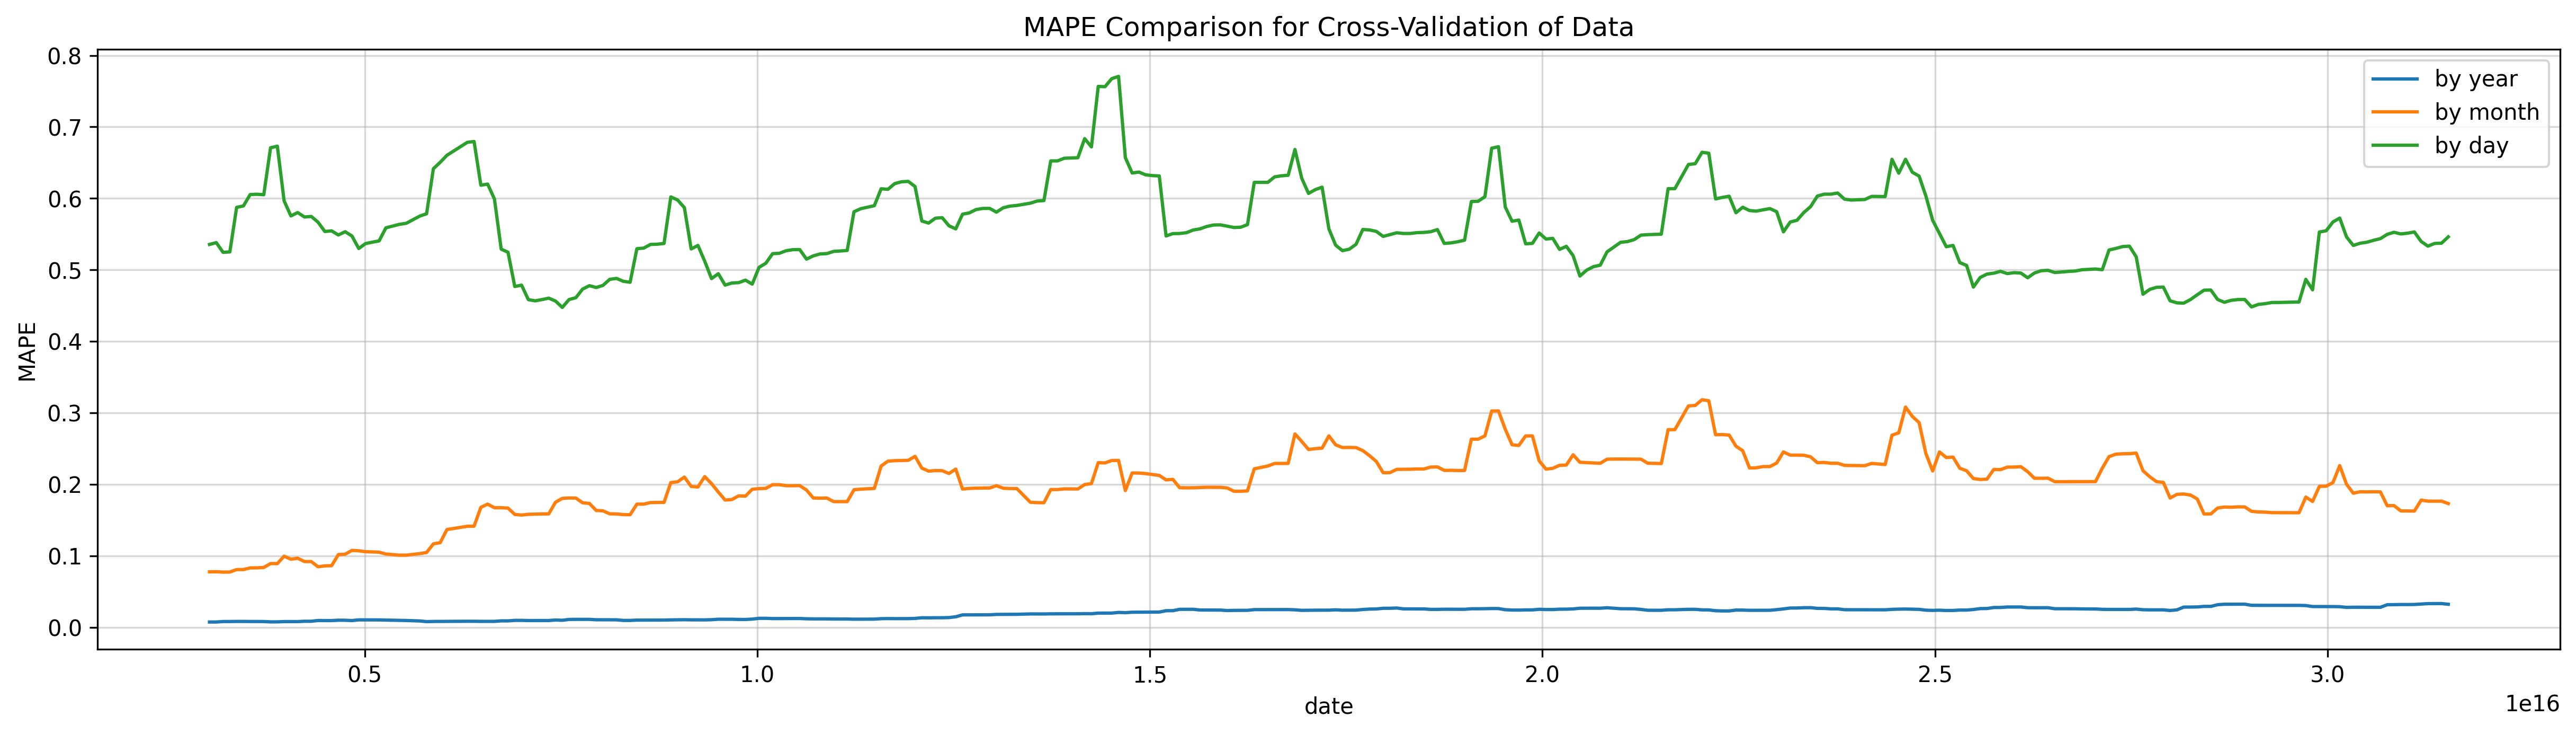

In [298]:
plt.figure(figsize=(20, 5), dpi=300)
plt.plot(df_p_by_year['horizon'],df_p_by_year['mape'],label="by year")
plt.plot(df_p_by_month['horizon'],df_p_by_month['mape'],label="by month")
plt.plot(df_p_by_day['horizon'],df_p_by_day['smape'],label="by day")
plt.legend()
plt.grid(True,alpha=0.5)
plt.title("MAPE Comparison for Cross-Validation of Data")
plt.xlabel("date")
plt.ylabel("MAPE")

Text(0, 0.5, 'RMSE')

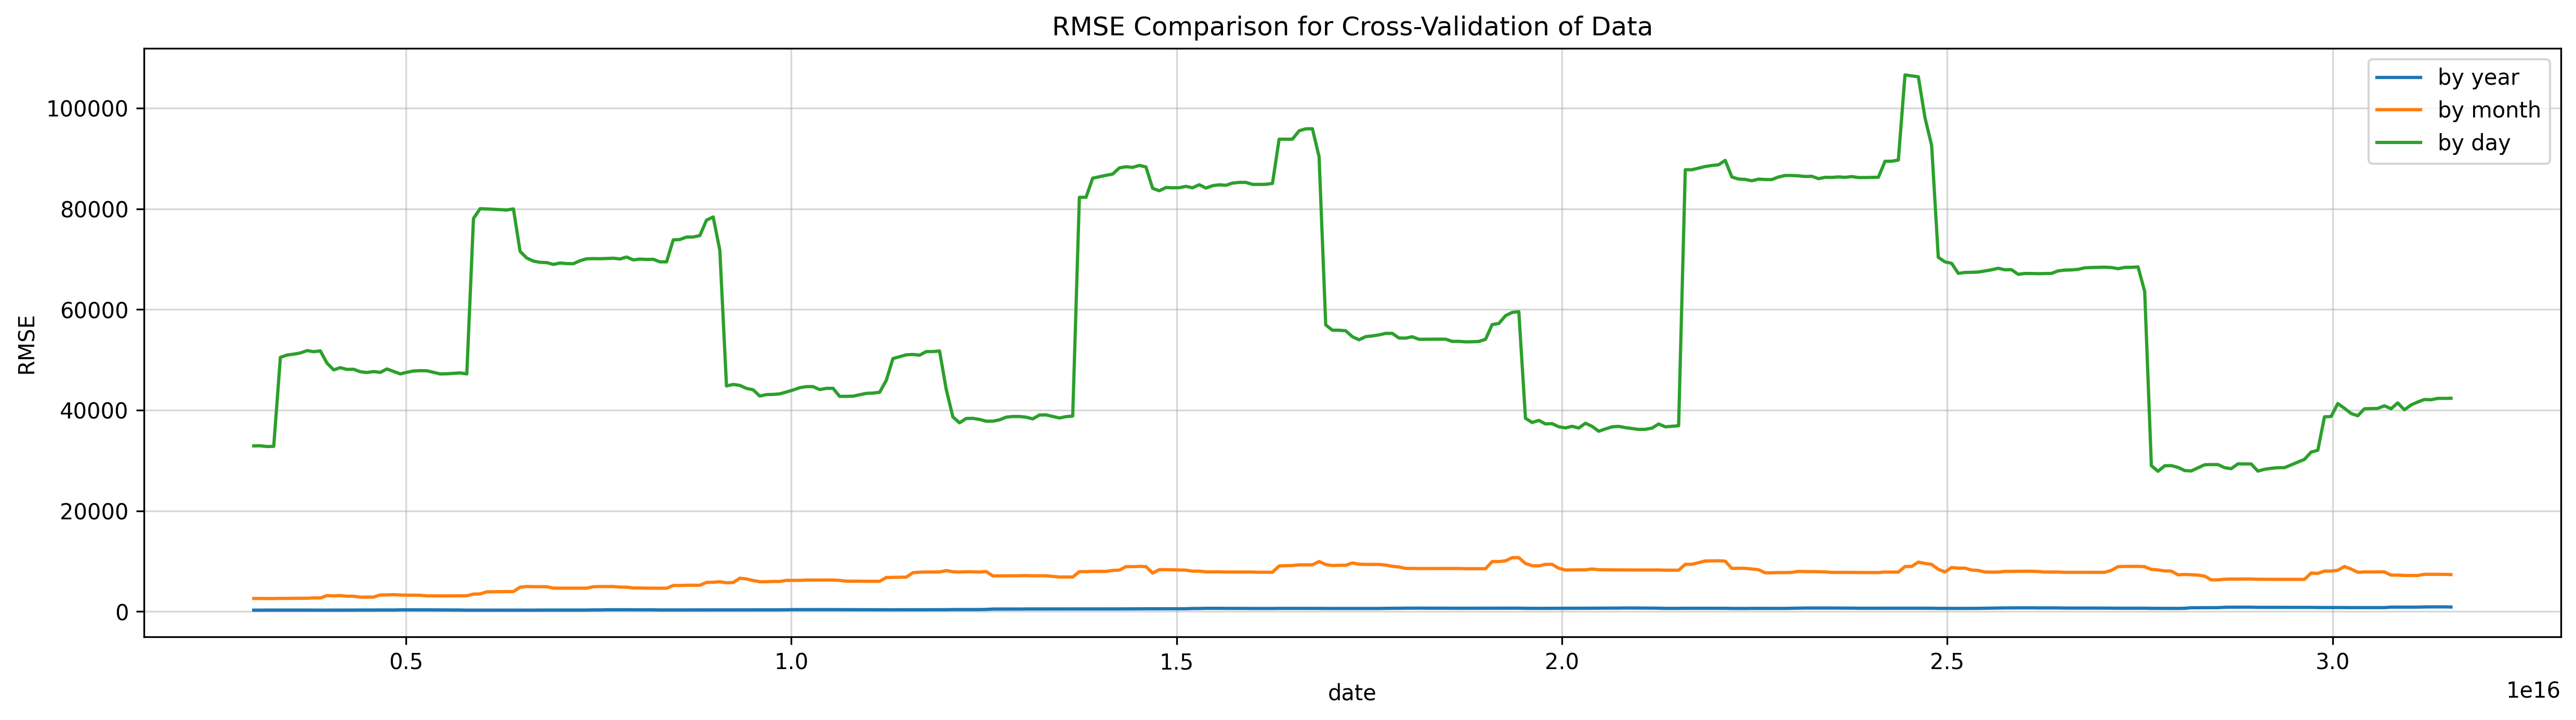

In [300]:
plt.figure(figsize=(20, 5), dpi=300)
plt.plot(df_p_by_year['horizon'],df_p_by_year['rmse'],label="by year")
plt.plot(df_p_by_month['horizon'],df_p_by_month['rmse'],label="by month")
plt.plot(df_p_by_day['horizon'],df_p_by_day['rmse'],label="by day")
plt.legend()
plt.grid(True,alpha=0.5)
plt.title("RMSE Comparison for Cross-Validation of Data")
plt.xlabel("date")
plt.ylabel("RMSE")

So we see that the cross-validation of the data by year produces the lowest MAPE score, as well as the lowest RMSE. This indicates that this data subset may be the best model for forecasting predictions of electricity consumption.

## Step Five: Predictions by Borough

In this section, we will compare predictions for each of the 5 boroughs.

In [282]:
bronx = df2[df2['Borough']=='BRONX'].dropna().reset_index(drop=True)
brooklyn = df2[df2['Borough']=='BROOKLYN'].dropna().reset_index(drop=True)
queens = df2[df2['Borough']=='QUEENS'].dropna().reset_index(drop=True)
manhattan = df2[df2['Borough']=='MANHATTAN'].dropna().reset_index(drop=True)
staten = df2[df2['Borough']=='STATEN ISLAND'].dropna().reset_index(drop=True)

In [283]:
def cross_validation_metrics(df):
    client = Client()  # connect to the cluster
    m = Prophet()
    m.fit(df)
    df_cv = cross_validation(m, initial='730 days', period='180 days', horizon='365 days', parallel='dask')
    df_p = performance_metrics(df_cv)
    client.close()   
    return(df_p)

In [284]:
bronx_by_year = bronx.rename(columns={'avg_by_year':'y'})[['ds','y','Borough']].dropna().reset_index(drop=True)
df_p_bronx = cross_validation_metrics(bronx_by_year)

19:01:20 - cmdstanpy - INFO - Chain [1] start processing
19:01:23 - cmdstanpy - INFO - Chain [1] done processing
19:01:24 - cmdstanpy - INFO - Chain [1] start processing
19:01:24 - cmdstanpy - INFO - Chain [1] done processing
19:01:24 - cmdstanpy - ERROR - Chain [1] error: error during processing Stale NFS file handle
19:01:24 - cmdstanpy - INFO - Chain [1] start processing
19:01:24 - cmdstanpy - INFO - Chain [1] start processing
Optimization terminated abnormally. Falling back to Newton.
19:01:25 - cmdstanpy - INFO - Chain [1] start processing
19:01:25 - cmdstanpy - INFO - Chain [1] start processing
19:01:25 - cmdstanpy - INFO - Chain [1] done processing
19:01:25 - cmdstanpy - INFO - Chain [1] start processing
19:01:25 - cmdstanpy - INFO - Chain [1] done processing
19:01:26 - cmdstanpy - INFO - Chain [1] start processing
19:01:26 - cmdstanpy - INFO - Chain [1] start processing
19:01:26 - cmdstanpy - INFO - Chain [1] start processing
19:01:26 - cmdstanpy - INFO - Chain [1] start proces

In [285]:
brooklyn_by_year = brooklyn.rename(columns={'avg_by_year':'y'})[['ds','y','Borough']].dropna().reset_index(drop=True)
df_p_brooklyn = cross_validation_metrics(brooklyn_by_year)

19:04:13 - cmdstanpy - INFO - Chain [1] start processing
19:04:19 - cmdstanpy - INFO - Chain [1] done processing
19:04:20 - cmdstanpy - INFO - Chain [1] start processing
19:04:20 - cmdstanpy - INFO - Chain [1] start processing
19:04:20 - cmdstanpy - INFO - Chain [1] done processing
19:04:20 - cmdstanpy - ERROR - Chain [1] error: error during processing Stale NFS file handle
19:04:20 - cmdstanpy - INFO - Chain [1] start processing
Optimization terminated abnormally. Falling back to Newton.
19:04:20 - cmdstanpy - INFO - Chain [1] start processing
19:04:20 - cmdstanpy - INFO - Chain [1] done processing
19:04:20 - cmdstanpy - INFO - Chain [1] start processing
19:04:21 - cmdstanpy - INFO - Chain [1] done processing
19:04:21 - cmdstanpy - INFO - Chain [1] start processing
19:04:22 - cmdstanpy - INFO - Chain [1] start processing
19:04:22 - cmdstanpy - INFO - Chain [1] start processing
19:04:22 - cmdstanpy - INFO - Chain [1] start processing
19:04:22 - cmdstanpy - INFO - Chain [1] start proces

In [286]:
queens_by_year = queens.rename(columns={'avg_by_year':'y'})[['ds','y','Borough']].dropna().reset_index(drop=True)
df_p_queens = cross_validation_metrics(queens_by_year)

19:09:56 - cmdstanpy - INFO - Chain [1] start processing
19:09:57 - cmdstanpy - INFO - Chain [1] done processing
19:09:58 - cmdstanpy - INFO - Chain [1] start processing
19:09:58 - cmdstanpy - INFO - Chain [1] start processing
19:09:58 - cmdstanpy - INFO - Chain [1] start processing
19:09:58 - cmdstanpy - INFO - Chain [1] start processing
19:09:59 - cmdstanpy - INFO - Chain [1] done processing
19:09:59 - cmdstanpy - INFO - Chain [1] done processing
19:09:59 - cmdstanpy - INFO - Chain [1] done processing
19:09:59 - cmdstanpy - INFO - Chain [1] done processing
19:10:00 - cmdstanpy - INFO - Chain [1] start processing
19:10:00 - cmdstanpy - INFO - Chain [1] start processing
19:10:00 - cmdstanpy - INFO - Chain [1] start processing
19:10:00 - cmdstanpy - INFO - Chain [1] start processing
19:10:00 - cmdstanpy - INFO - Chain [1] done processing
19:10:00 - cmdstanpy - INFO - Chain [1] start processing
19:10:00 - cmdstanpy - INFO - Chain [1] start processing
19:10:00 - cmdstanpy - INFO - Chain [

In [287]:
manhattan_by_year = manhattan.rename(columns={'avg_by_year':'y'})[['ds','y','Borough']].dropna().reset_index(drop=True)
df_p_manhattan = cross_validation_metrics(manhattan_by_year)

19:10:09 - cmdstanpy - INFO - Chain [1] start processing
19:10:14 - cmdstanpy - INFO - Chain [1] done processing
19:10:15 - cmdstanpy - INFO - Chain [1] start processing
19:10:15 - cmdstanpy - INFO - Chain [1] start processing
19:10:15 - cmdstanpy - INFO - Chain [1] start processing
19:10:15 - cmdstanpy - INFO - Chain [1] done processing
19:10:15 - cmdstanpy - ERROR - Chain [1] error: error during processing Stale NFS file handle
19:10:15 - cmdstanpy - INFO - Chain [1] start processing
Optimization terminated abnormally. Falling back to Newton.
19:10:15 - cmdstanpy - INFO - Chain [1] start processing
19:10:15 - cmdstanpy - INFO - Chain [1] done processing
19:10:16 - cmdstanpy - INFO - Chain [1] start processing
19:10:16 - cmdstanpy - INFO - Chain [1] start processing
19:10:16 - cmdstanpy - INFO - Chain [1] start processing
19:10:16 - cmdstanpy - INFO - Chain [1] start processing
19:10:16 - cmdstanpy - INFO - Chain [1] start processing
19:10:16 - cmdstanpy - INFO - Chain [1] start proce

In [288]:
staten_by_year = staten.rename(columns={'avg_by_year':'y'})[['ds','y','Borough']].dropna().reset_index(drop=True)
df_p_staten = cross_validation_metrics(staten_by_year)

19:13:35 - cmdstanpy - INFO - Chain [1] start processing
19:13:36 - cmdstanpy - INFO - Chain [1] done processing
19:13:37 - cmdstanpy - INFO - Chain [1] start processing
19:13:37 - cmdstanpy - INFO - Chain [1] start processing
19:13:37 - cmdstanpy - INFO - Chain [1] start processing
19:13:37 - cmdstanpy - INFO - Chain [1] start processing
19:13:37 - cmdstanpy - INFO - Chain [1] done processing
19:13:37 - cmdstanpy - INFO - Chain [1] done processing
19:13:37 - cmdstanpy - INFO - Chain [1] done processing
19:13:37 - cmdstanpy - INFO - Chain [1] start processing
19:13:38 - cmdstanpy - INFO - Chain [1] start processing
19:13:38 - cmdstanpy - INFO - Chain [1] start processing
19:13:38 - cmdstanpy - INFO - Chain [1] done processing
19:13:38 - cmdstanpy - INFO - Chain [1] start processing
19:13:38 - cmdstanpy - INFO - Chain [1] start processing
19:13:38 - cmdstanpy - INFO - Chain [1] start processing
19:13:38 - cmdstanpy - INFO - Chain [1] start processing
19:13:38 - cmdstanpy - INFO - Chain 

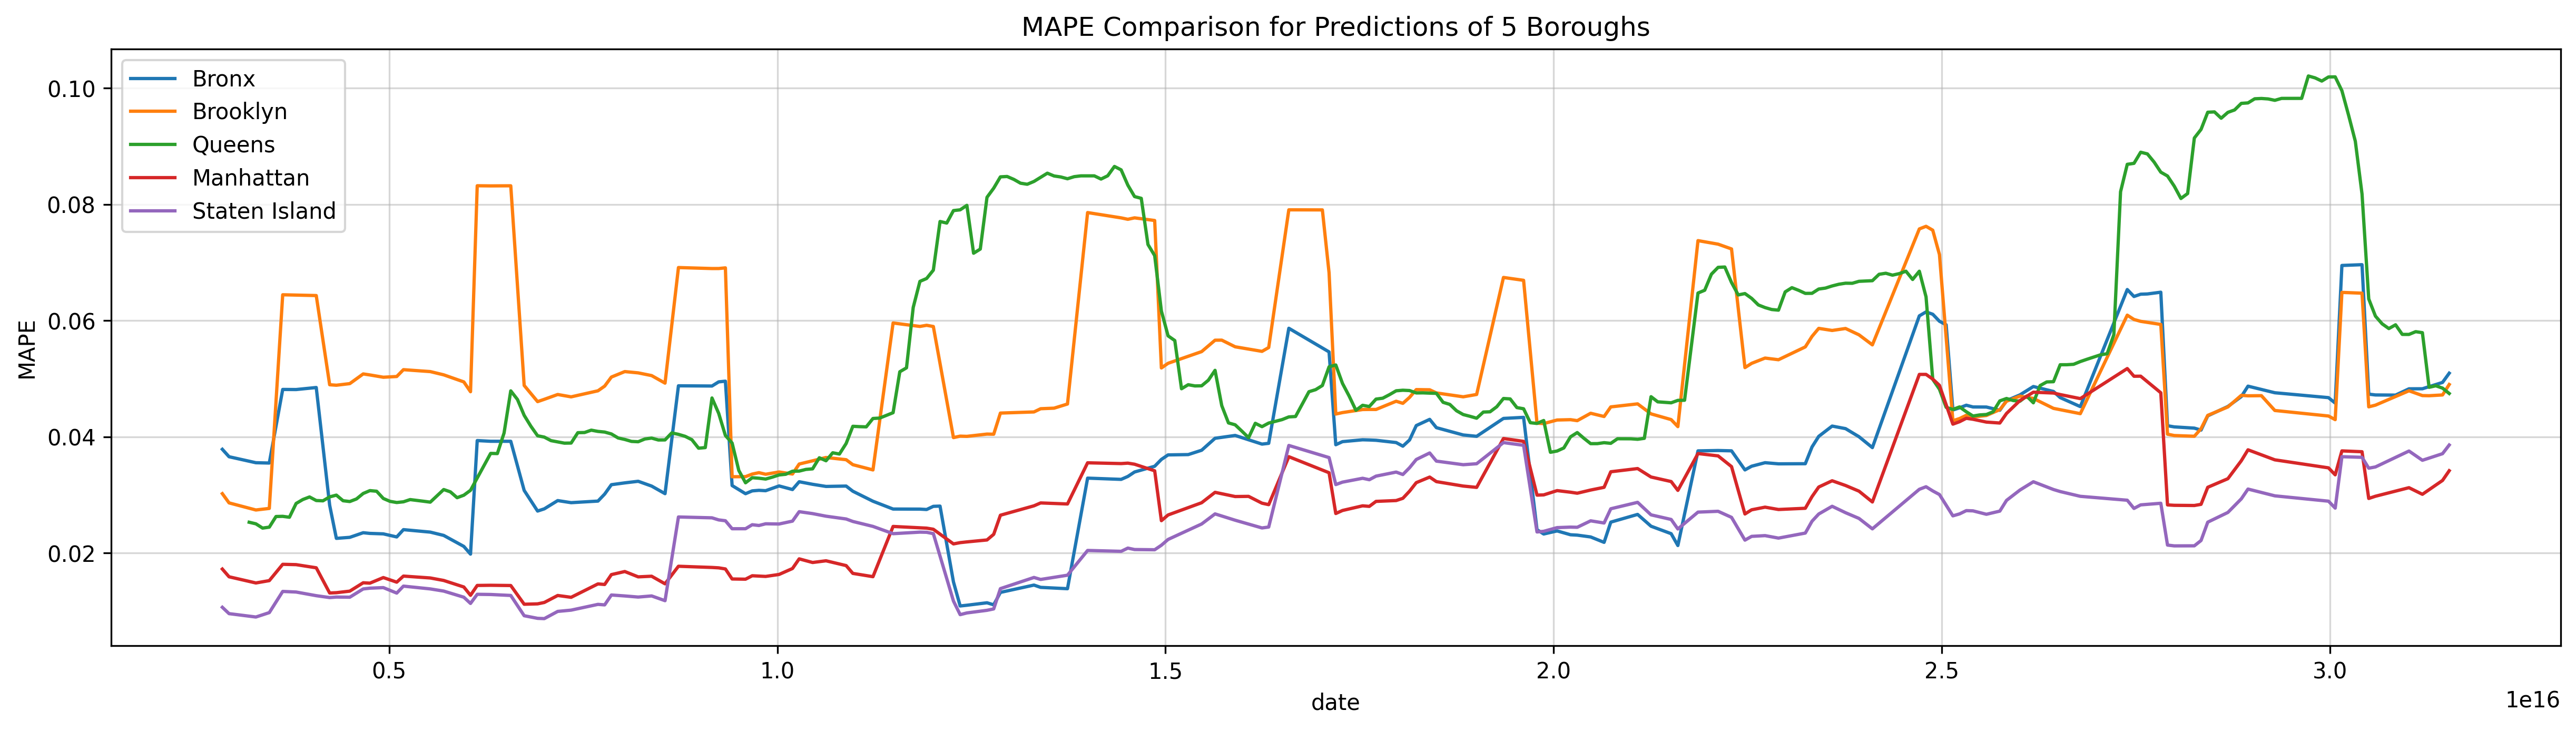

In [293]:
plt.figure(figsize=(20, 5), dpi=300)
plt.plot(df_p_bronx['horizon'],df_p_bronx['mape'],label="Bronx")
plt.plot(df_p_brooklyn['horizon'],df_p_brooklyn['mape'],label="Brooklyn")
plt.plot(df_p_queens['horizon'],df_p_queens['mape'],label="Queens")
plt.plot(df_p_manhattan['horizon'],df_p_manhattan['mape'],label="Manhattan")
plt.plot(df_p_staten['horizon'],df_p_staten['mape'],label="Staten Island")
plt.legend()
plt.grid(True,alpha=0.5)
plt.title("MAPE Comparison for Predictions of 5 Boroughs")
plt.xlabel("date")
plt.ylabel("MAPE")
plt.show()

The cross-validation of the data shows that the forecasting for electricity consumption is the best for Staten Island, as it consistently has the lowest MAPE score.

## Conclusion

In this project, we analyzed the energy consumption in KWH of the 5 boroughs in New York in the time span of 2011 - 2022. This is a real-world dataset we obtained from the official website, and we performed time-series forecasting on the dataset in numerous ways, such as applying growth models (linear, logistic, flat), applying seasonalities (monthly, yearly), applying changepoints, performing hyperparameter tuning using cross-validation, and using cross-validation to extract and compare the Mean Absolute Percentage Error (MAPE) to get a sense of which forecasting model performed best. We also analyzed the energy consumption for each of the 5 boroughs and applied time-series forecasting to predict 1 year into the future. We learned that in all instances, forecasting by taking the average of the data by year produces best results.